In [1]:
import pandas as pd
pd.set_option('display.expand_frame_repr', False)

import matplotlib
import matplotlib.pyplot as plt
font = {'size' : 20}
matplotlib.rc('font', **font)

import seaborn as sns

from pylab import rcParams
rcParams["figure.figsize"] = 30,16

import sklearn
from sklearn import metrics

import numpy as np
import scipy

import datetime as dt
from datetime import date

from collections import OrderedDict

import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, "../")
import functions

In [2]:
#Daten aus CSV-Datei laden
df = pd.read_csv("Datenbeschaffung/verbrauch.csv", index_col=0, parse_dates=True)
df.index.freq = "D"

print(df)
print()
print(df.describe().transpose())

            verbrauch     monat   wochentag feiertag  arbeitstag
datum                                                           
2015-01-01     126197    Januar  Donnerstag  Neujahr           0
2015-01-02     147085    Januar     Freitag      NaN           1
2015-01-03     141426    Januar     Samstag      NaN           0
2015-01-04     132446    Januar     Sonntag      NaN           0
2015-01-05     152611    Januar      Montag      NaN           1
...               ...       ...         ...      ...         ...
2021-12-27     153489  Dezember      Montag      NaN           1
2021-12-28     155182  Dezember    Dienstag      NaN           1
2021-12-29     153611  Dezember    Mittwoch      NaN           1
2021-12-30     148126  Dezember  Donnerstag      NaN           1
2021-12-31     137327  Dezember     Freitag      NaN           1

[2557 rows x 5 columns]

             count           mean           std       min       25%       50%       75%       max
verbrauch   2557.0  169329.0633

# <font size="7"> Datenanalyse<a class="anchor" id="02-01-datenanalyse"></a> </font>

## <font size="6"> Stromverbrauch nach Jahren <a class="anchor" id="2-01-stromverbrauchnachjahren"></a>

<font size="5">
Der Stromverbrauch folgt einem deutlichen, jährlichen Muster. Er ist im Januar mit durchschnittlich circa 200.000 MWh besonders hoch und fällt dann bis etwa Mai um etwa 20 % auf durchschnittlich 160.000 MWh ab, wobei vor allem im April gelegentlich signifikante Unregelmäßigkeiten erkennbar sind. Im Juni und Juli steigt der Verbrauch wieder auf durchschnittlich 170.000 MWh und fällt bis September auf durchschnittlich 160.000 MWh ab. Ab September steigt der Verbrauch dann auf durchschnittlich 180.000 bis 190.000 MWh an. Auffällig ist außerdem ein starker Abfall des Stromverbrauchs auf etwa 140.000 MWh Ende Dezember. Es lässt sich hier also eine deutliche jährliche Saisonalität erkennen.
</font>

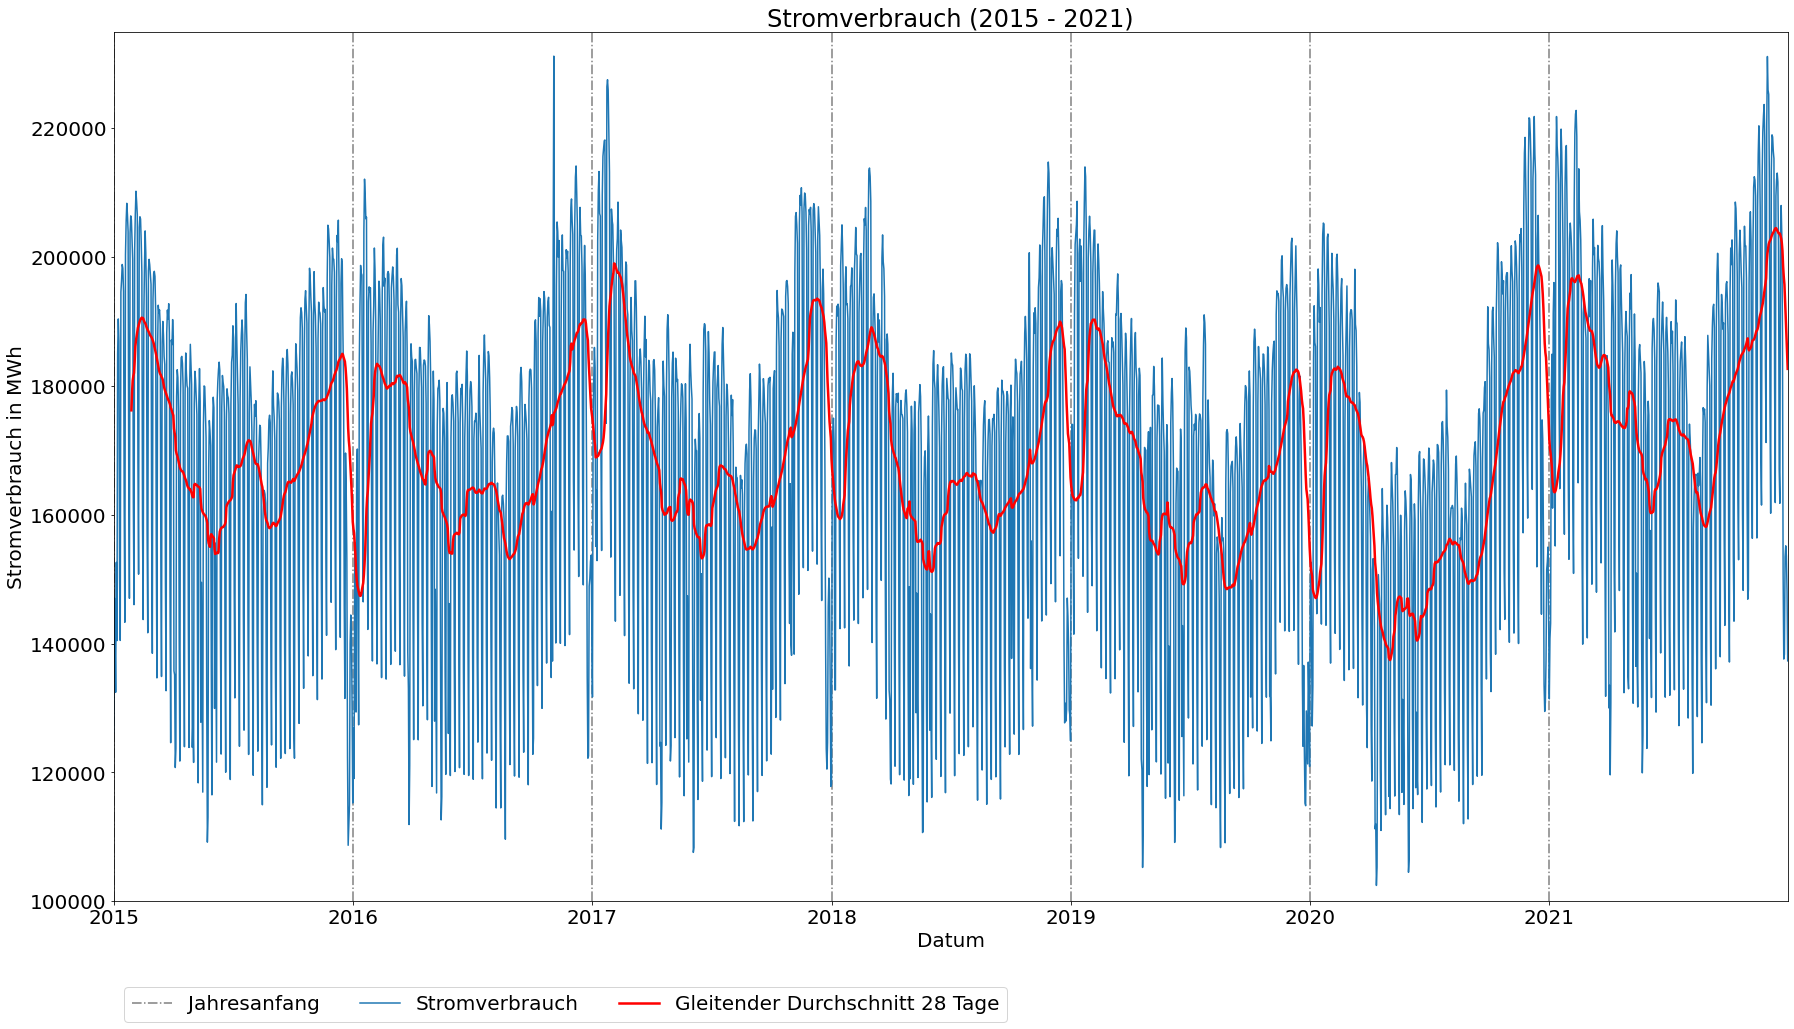

In [3]:
functions.draw_years(df)

#Stromverbrauch plotten
plt.plot(df["verbrauch"], label="Stromverbrauch");
plt.plot(df["verbrauch"].rolling(window=28).mean(), color="red", linewidth=2.5, label="Gleitender Durchschnitt 28 Tage")

#Achsen und Layout
plt.title("Stromverbrauch (2015 - 2021)")
plt.ylabel("Stromverbrauch in MWh")
plt.ylim(100000,235000)
plt.xlabel("Datum")
plt.xlim(dt.datetime(2015,1,1), dt.datetime(2021,12,31))

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.15), ncol=5)

plt.show()

<a class="anchor" id="01-01-gleitendedurchschnitte"></a>

<font size="5">Beim Übereinanderlegen der gleitenden 7- und 14-Tage-Durchschnitte fällt auf, dass der Stromverbrauch von 2015 bis 2019 dem oben beschriebenen Muster folgt. Im Jahr 2020 wich der Verbrauch aufgrund der Maßnahmen im Zuge der Corona-Pandemie im ersten Halbjahr stark nach unten ab. Im Zeitraum von März bis April wurden besonders strenge Anticorona-Maßnahmen verhangen („Lockdown“). Dies hatte starke Auswirkungen auf die gesamte Volkswirtschaft und damit auch auf Industrie und Gewerbe, wodurch der Stromverbrauch stark sank. Ab April/Mai wurden die Maßnahmen vor Allem für die Industrie weitestgehend zurückgenommen, auch die Maßnahmen im Gewerbe/Handel wurden im zweiten Halbjahr wieder reduziert. Dadurch normalisierte sich der Stromverbrauch zunächst wieder einigermaßen. Gleichzeitig ist der Stromverbrauch im Telekommunikationsbereich und bei den privaten Haushalten nachhaltig angestiegen. Dadurch liegt der Stromverbrauch seit dem dritten Quartal 2020 über dem Stromverbrauch der letzten Jahre.</font>

<a class="anchor" id="2-01-gleitendedurchschnitte"></a>

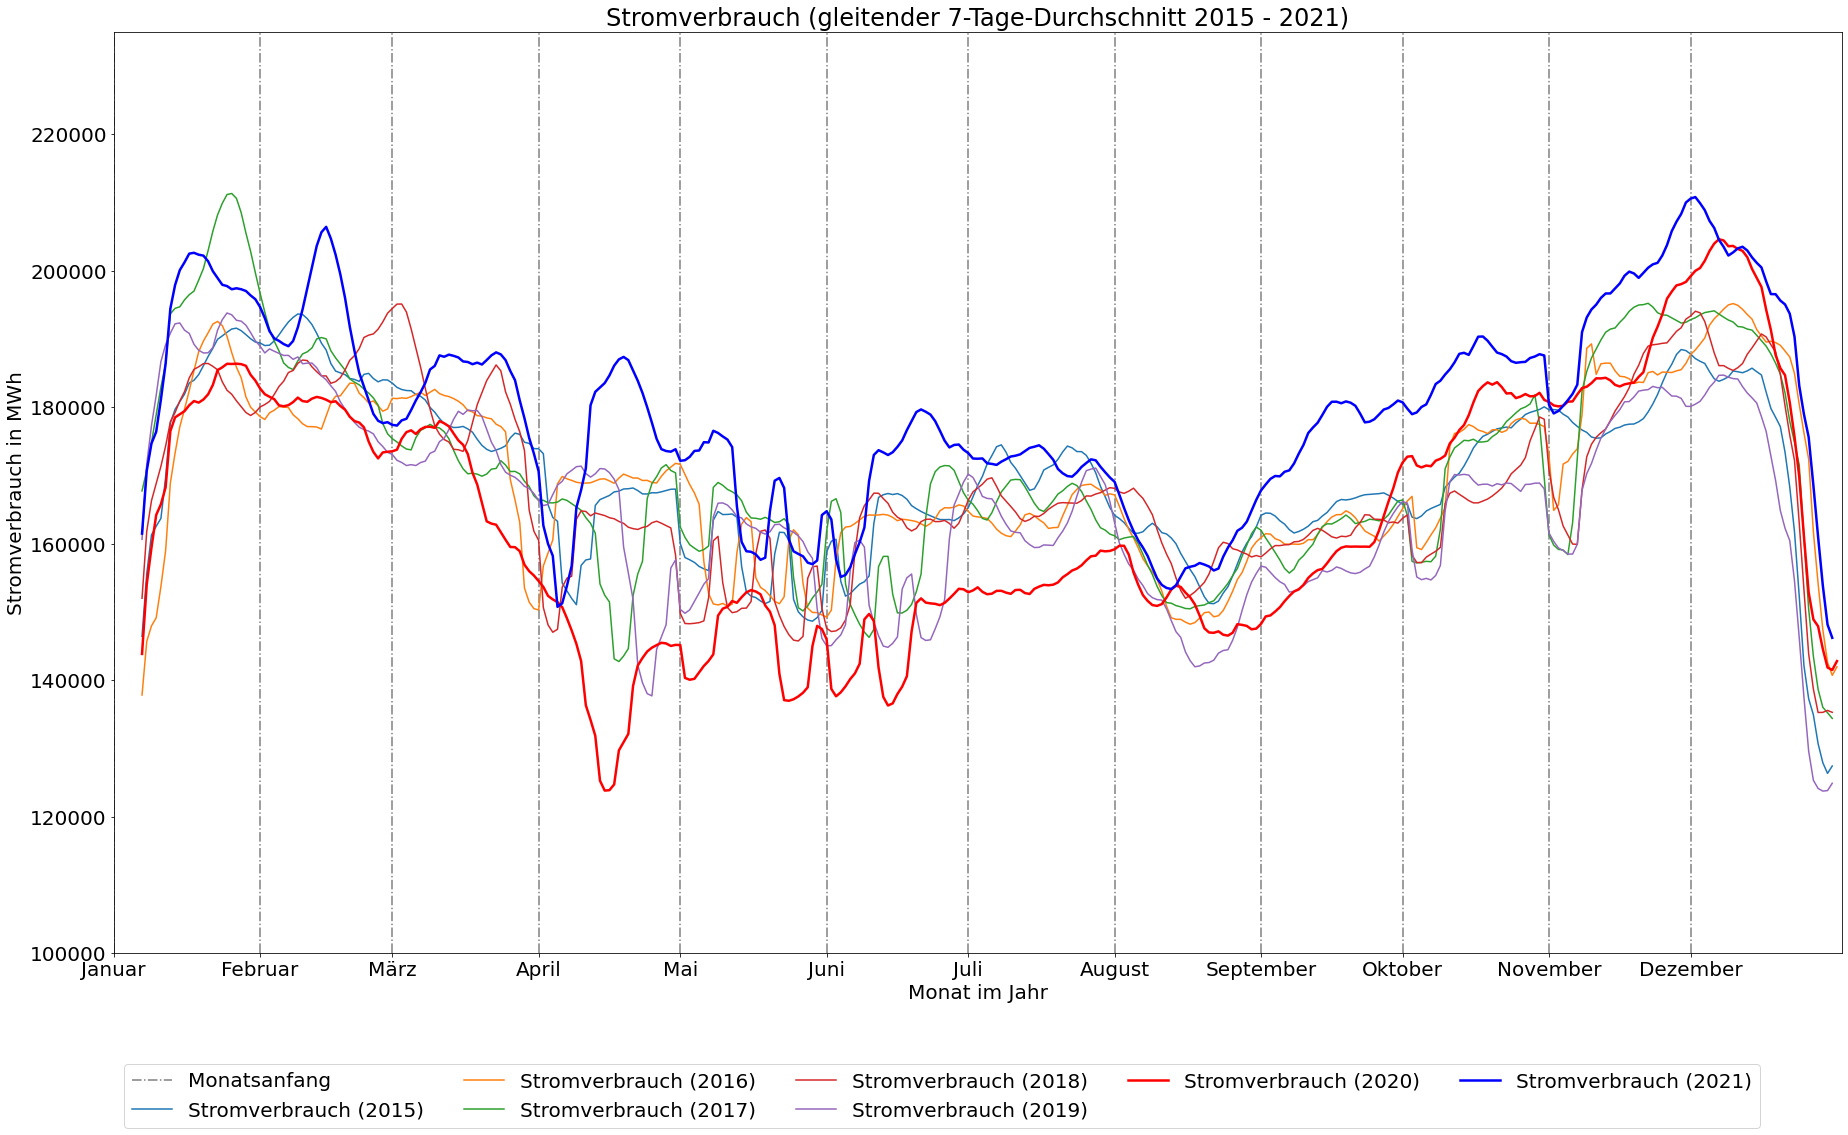

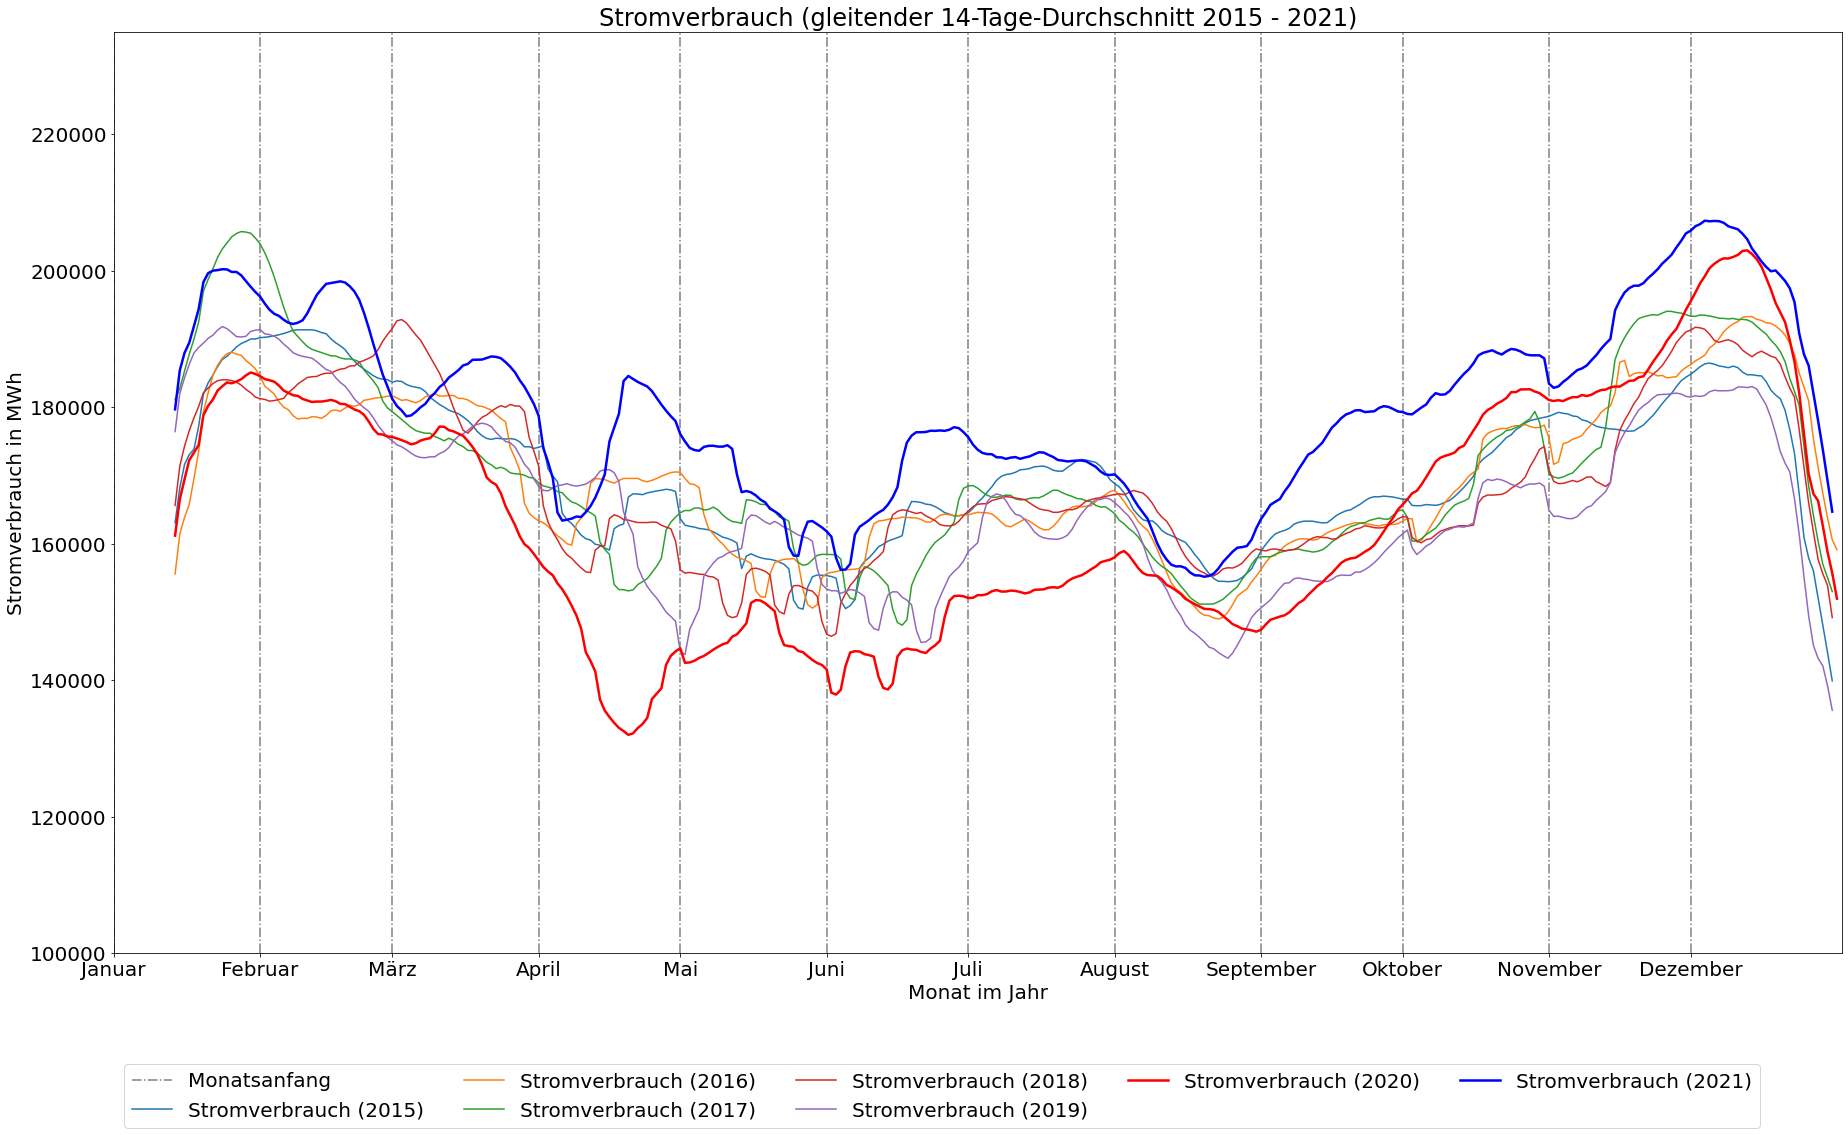

In [4]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

#Monatsanfang plotten
for i in [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]:
    
    ax.axvline(x=i, ymin=0, ymax=1, color="grey", linestyle="-.", label="Monatsanfang")

#Stromverbräuche plotten
ax.plot(df["2015-01-01":"2015-12-31"]["verbrauch"].rolling(window=7).mean().values, label="Stromverbrauch (2015)");
ax.plot(df["2016-01-01":"2016-12-31"]["verbrauch"].rolling(window=7).mean().values, label="Stromverbrauch (2016)");
ax.plot(df["2017-01-01":"2017-12-31"]["verbrauch"].rolling(window=7).mean().values, label="Stromverbrauch (2017)");
ax.plot(df["2018-01-01":"2018-12-31"]["verbrauch"].rolling(window=7).mean().values, label="Stromverbrauch (2018)");
ax.plot(df["2019-01-01":"2019-12-31"]["verbrauch"].rolling(window=7).mean().values, label="Stromverbrauch (2019)");
ax.plot(df["2020-01-01":"2020-12-31"]["verbrauch"].rolling(window=7).mean().values, color="red", linewidth=2.5, label="Stromverbrauch (2020)");
ax.plot(df["2021-01-01":"2021-12-31"]["verbrauch"].rolling(window=7).mean().values, color="blue", linewidth=2.5, label="Stromverbrauch (2021)");

#Achsen und Layout
ax.set_title("Stromverbrauch (gleitender 7-Tage-Durchschnitt 2015 - 2021)")
ax.set_ylabel("Stromverbrauch in MWh")
ax.set_ylim(100000,235000)
ax.set_xlabel("Monat im Jahr")
ax.set_xlim(0,366)
ax.set_xticks([0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334])
ax.set_xticklabels(["Januar", "Februar", "März", "April", "Mai", "Juni", "Juli", "August", "September", "Oktober", "November", "Dezember"])

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.2), ncol=5)

plt.show()

print("\n\n\n")

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

#Monatsanfang plotten
for i in [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]:
    
    ax.axvline(x=i, ymin=0, ymax=1, color="grey", linestyle="-.", label="Monatsanfang")

#Stromverbräuche plotten
ax.plot(df["2015-01-01":"2015-12-31"]["verbrauch"].rolling(window=14).mean().values, label="Stromverbrauch (2015)");
ax.plot(df["2016-01-01":"2016-12-31"]["verbrauch"].rolling(window=14).mean().values, label="Stromverbrauch (2016)");
ax.plot(df["2017-01-01":"2017-12-31"]["verbrauch"].rolling(window=14).mean().values, label="Stromverbrauch (2017)");
ax.plot(df["2018-01-01":"2018-12-31"]["verbrauch"].rolling(window=14).mean().values, label="Stromverbrauch (2018)");
ax.plot(df["2019-01-01":"2019-12-31"]["verbrauch"].rolling(window=14).mean().values, label="Stromverbrauch (2019)");
ax.plot(df["2020-01-01":"2020-12-31"]["verbrauch"].rolling(window=14).mean().values, color="red", linewidth=2.5, label="Stromverbrauch (2020)");
ax.plot(df["2021-01-01":"2021-12-31"]["verbrauch"].rolling(window=14).mean().values, color="blue", linewidth=2.5, label="Stromverbrauch (2021)");

#Achsen und Layout
ax.set_title("Stromverbrauch (gleitender 14-Tage-Durchschnitt 2015 - 2021)")
ax.set_ylim(100000,235000)
ax.set_ylabel("Stromverbrauch in MWh")
ax.set_xlim(0,366)
ax.set_xticks([0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334])
ax.set_xticklabels(["Januar", "Februar", "März", "April", "Mai", "Juni", "Juli", "August", "September", "Oktober", "November", "Dezember"])
ax.set_xlabel("Monat im Jahr")

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.2), ncol=5)

plt.show()

<a class="anchor" id="2-01-stromverbrauchnachjahreneinzelnd"></a>

<a class="anchor" id="01-01-nachjahreneinzelnd"></a>
<font size="5">
Bei näherer Betrachtung der einzelnen Jahre ist die oben beschriebene Saisonalität ebenfalls erkennbar. Auffällig ist allerdings auch, dass es eine deutliche wöchentliche Saisonalität gibt. Außerdem führen Feiertage zu signifikanten Abweichungen vom ansonsten zu erwartenden Verbrauch.
</font>



 2015 -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------




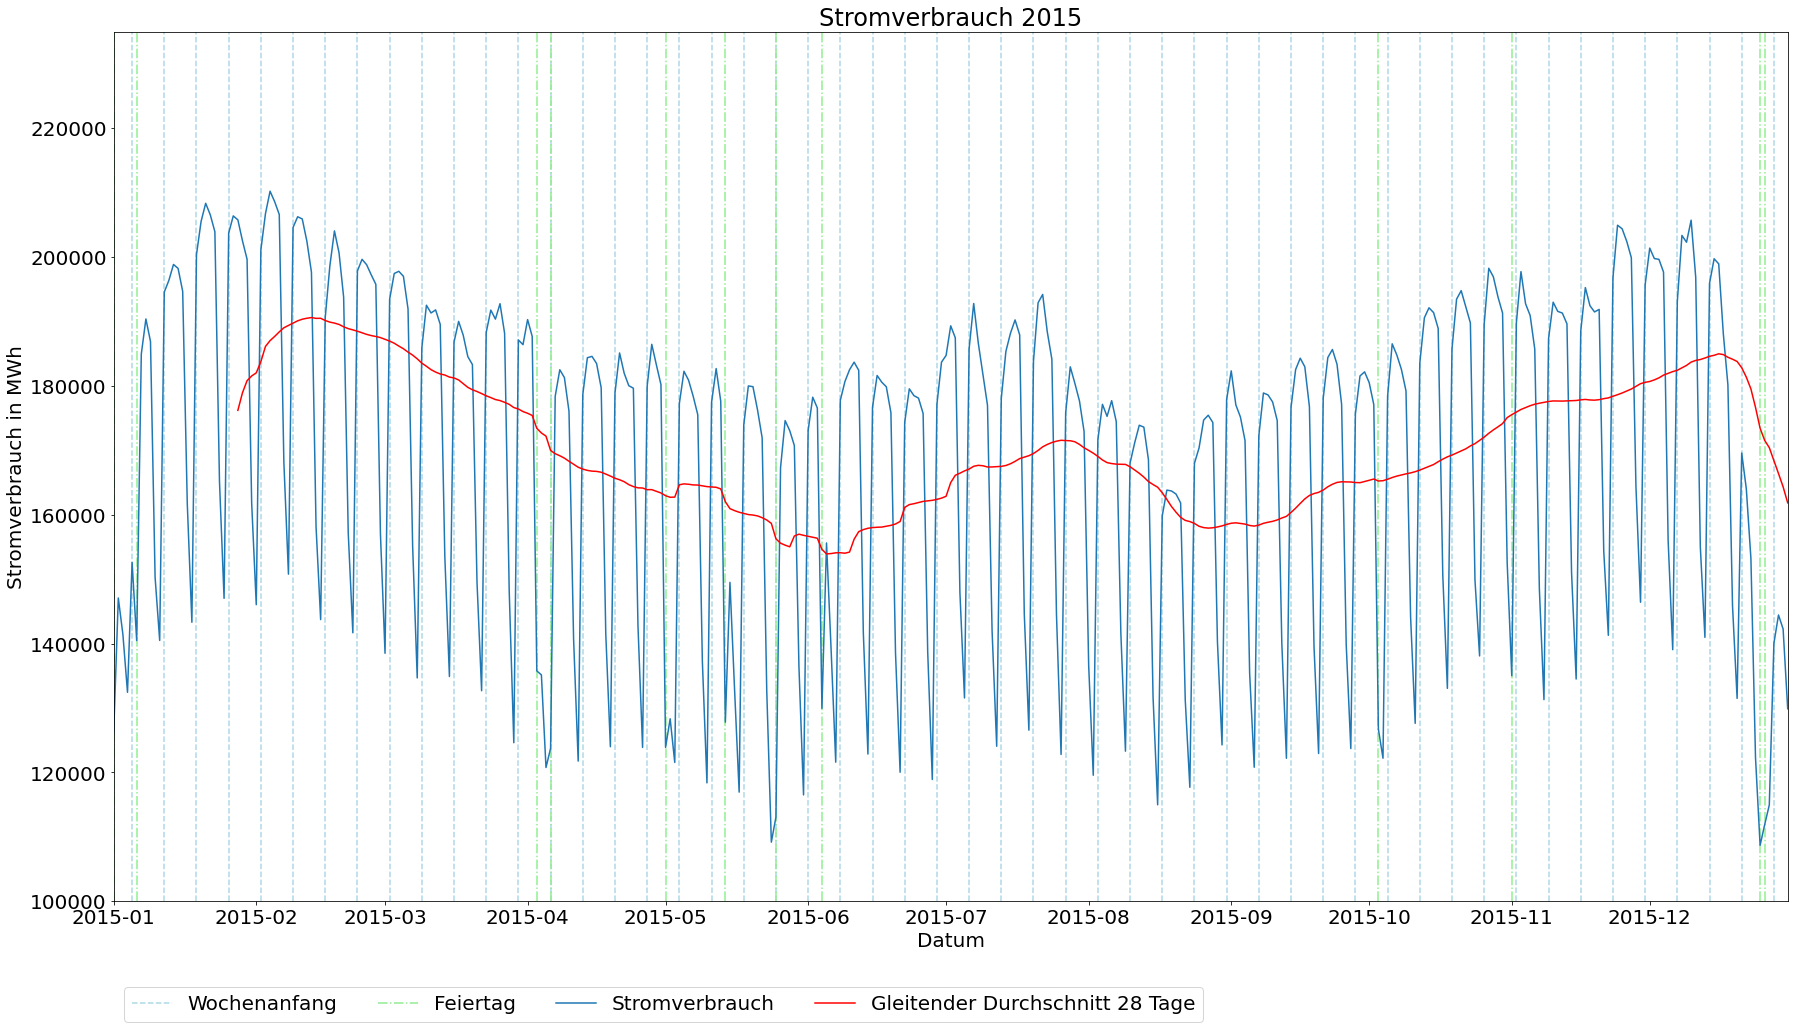

count       365.000000
mean     169613.986301
std       26237.616428
min      108698.000000
25%      145909.000000
50%      178084.000000
75%      189784.000000
max      210222.000000
Name: verbrauch, dtype: float64


 2016 -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------




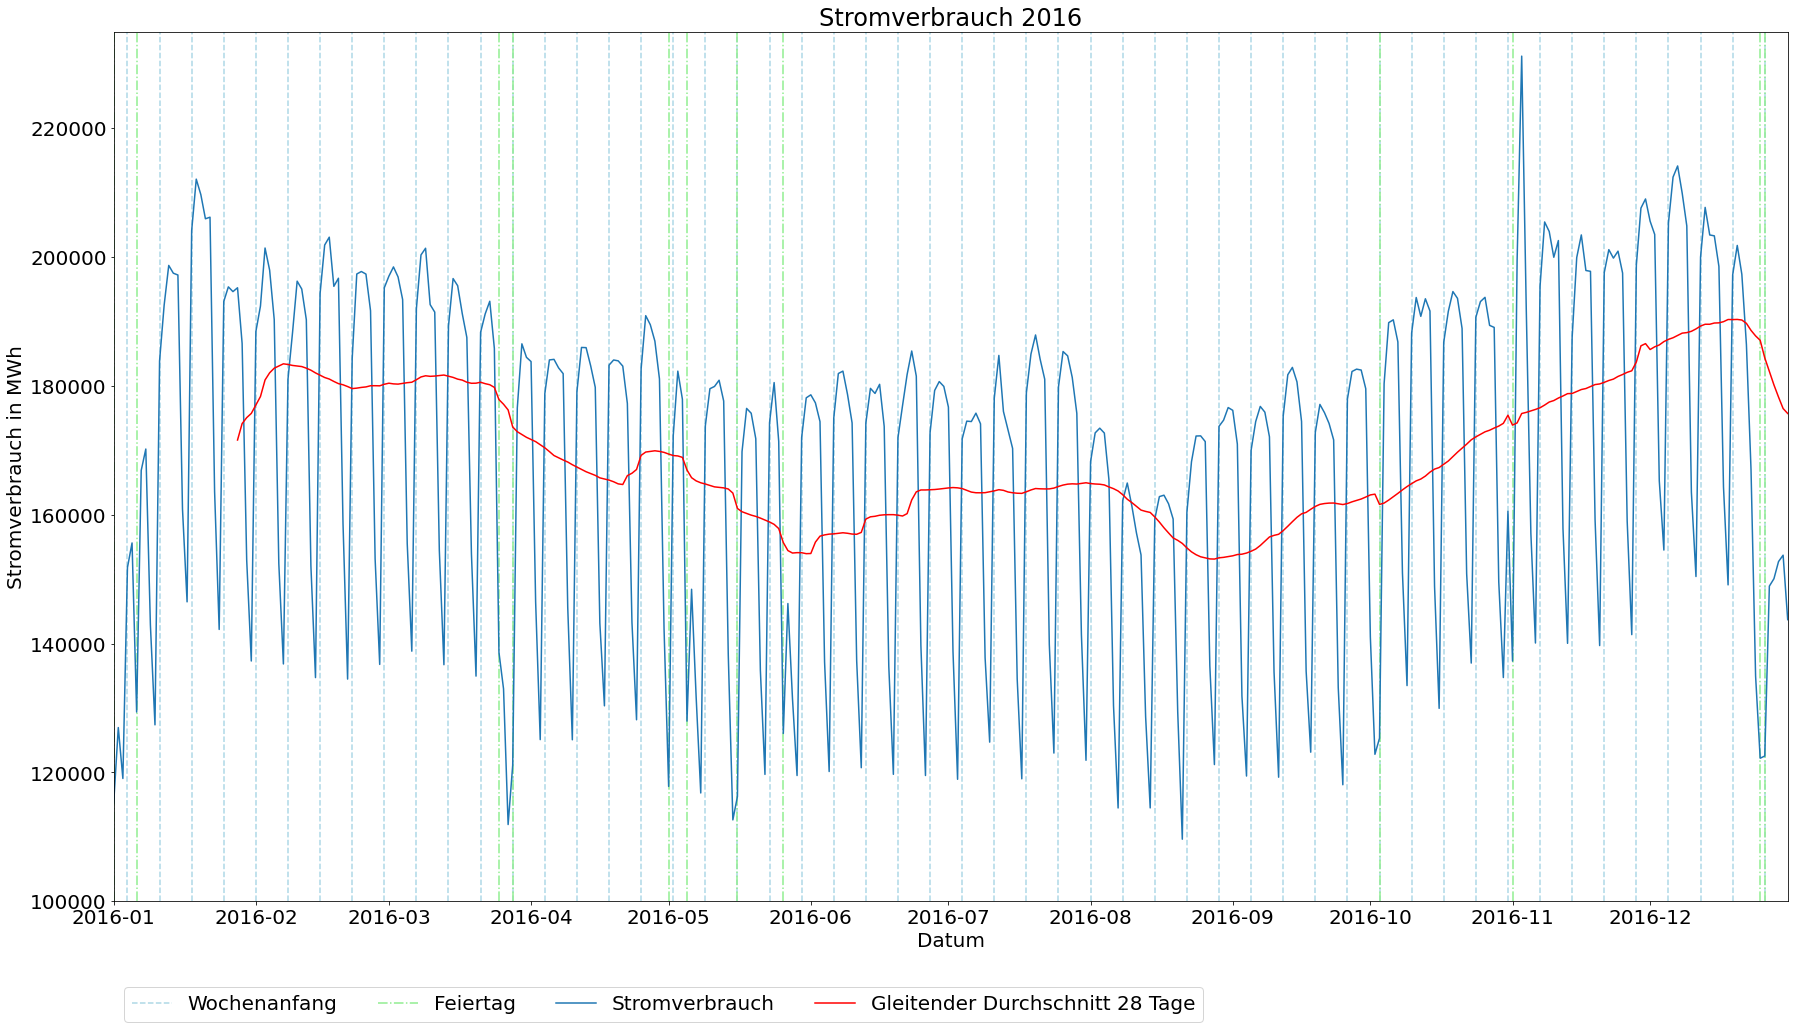

count       366.000000
mean     169040.931694
std       26517.670928
min      109644.000000
25%      146972.250000
50%      175979.000000
75%      189741.250000
max      231190.000000
Name: verbrauch, dtype: float64


 2017 -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------




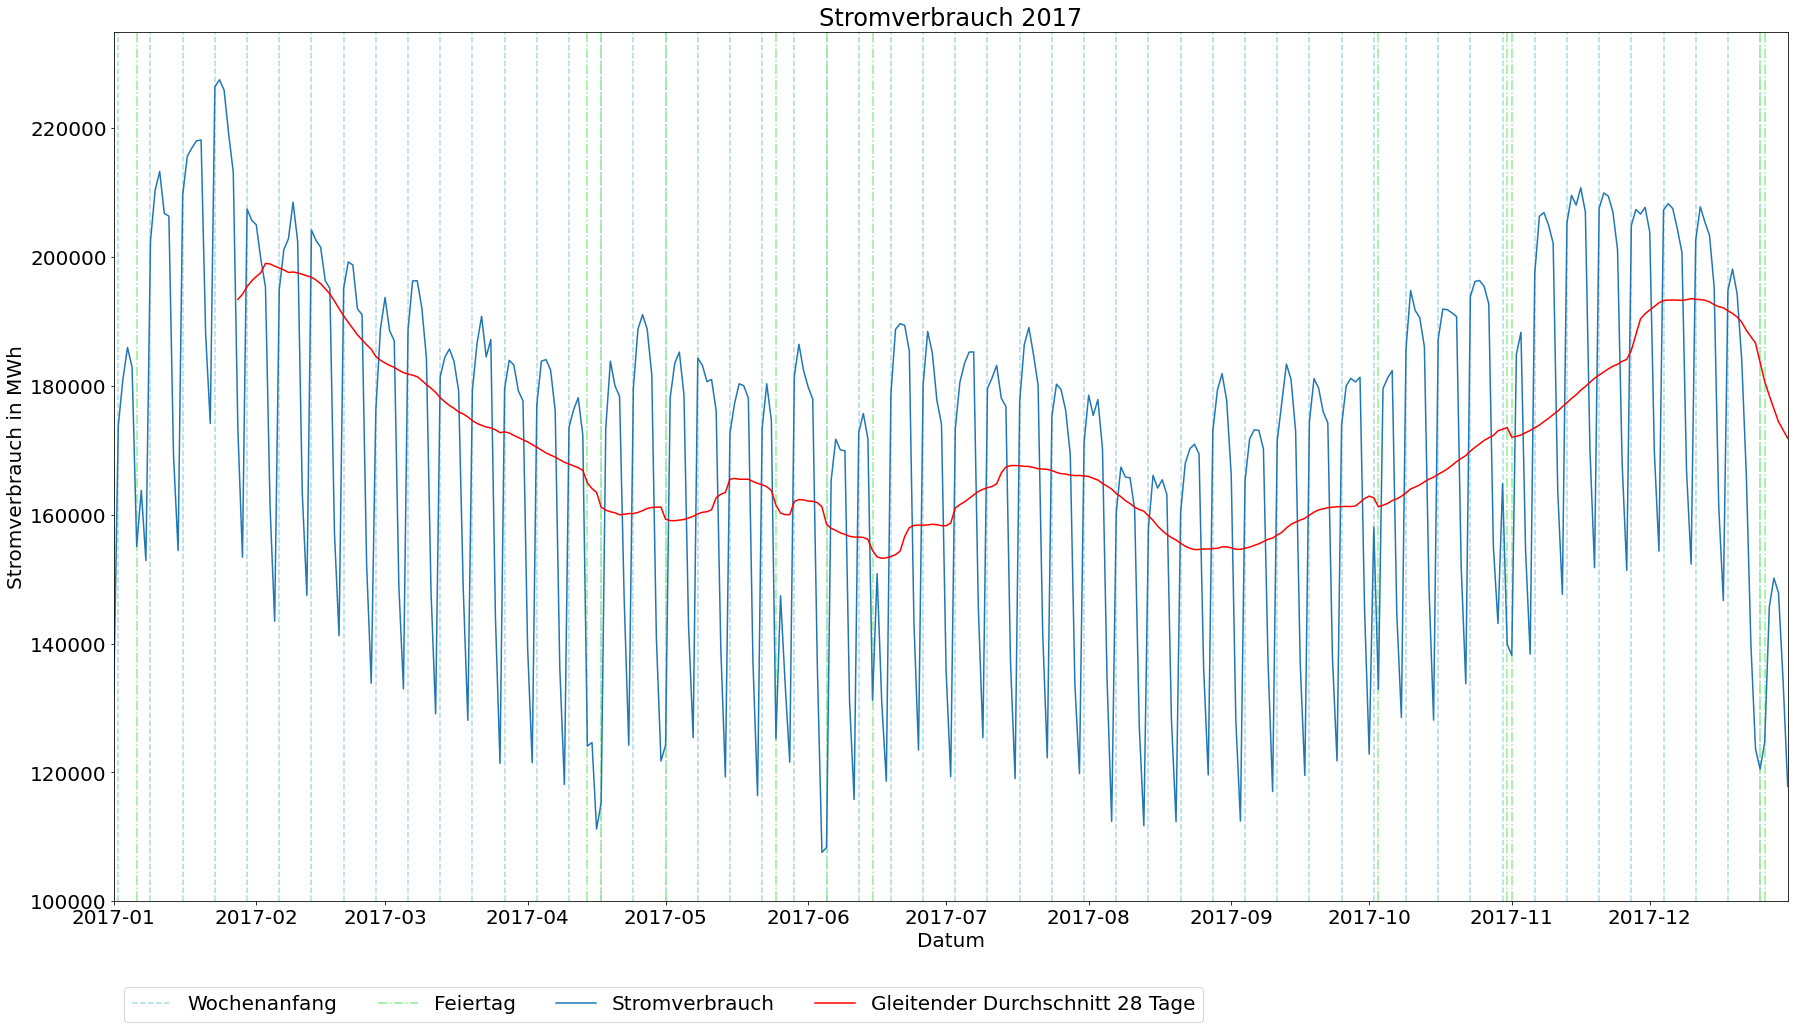

count       365.000000
mean     170383.227397
std       27720.512011
min      107596.000000
25%      148686.000000
50%      177597.000000
75%      188807.000000
max      227529.000000
Name: verbrauch, dtype: float64


 2018 -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------




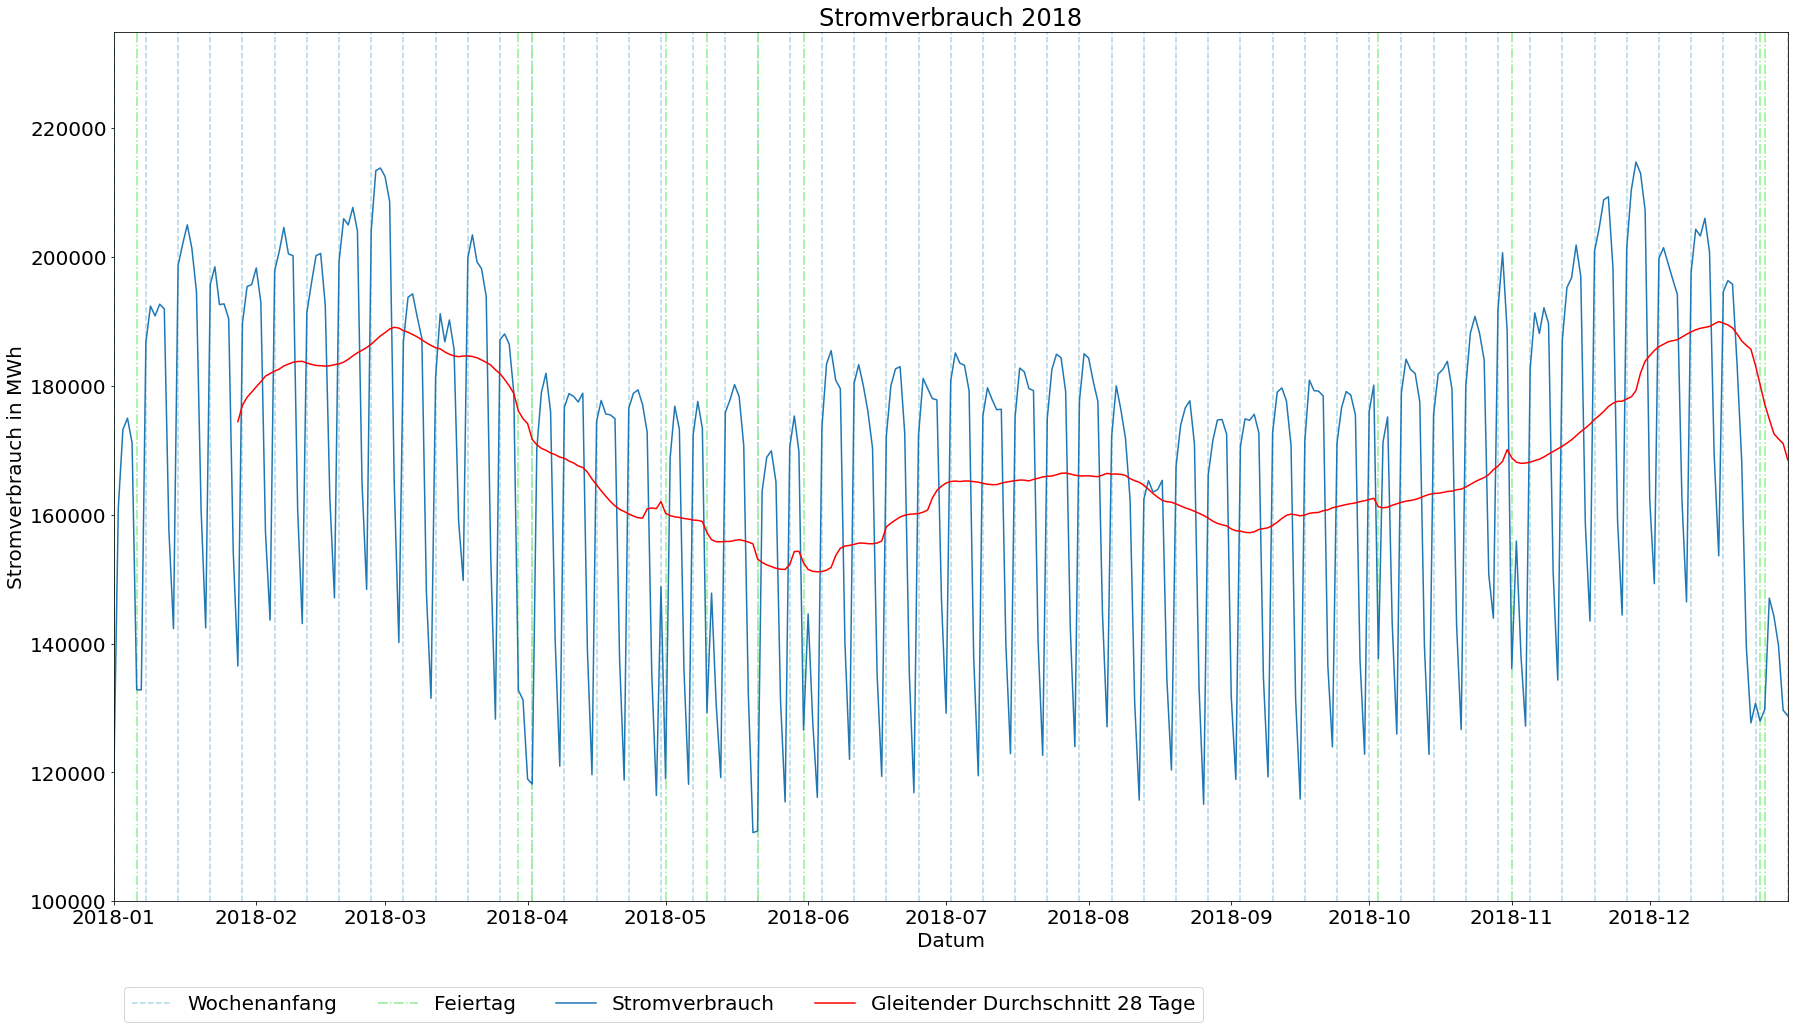

count       365.000000
mean     168303.627397
std       26262.745782
min      110677.000000
25%      144438.000000
50%      175640.000000
75%      186844.000000
max      214748.000000
Name: verbrauch, dtype: float64


 2019 -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------




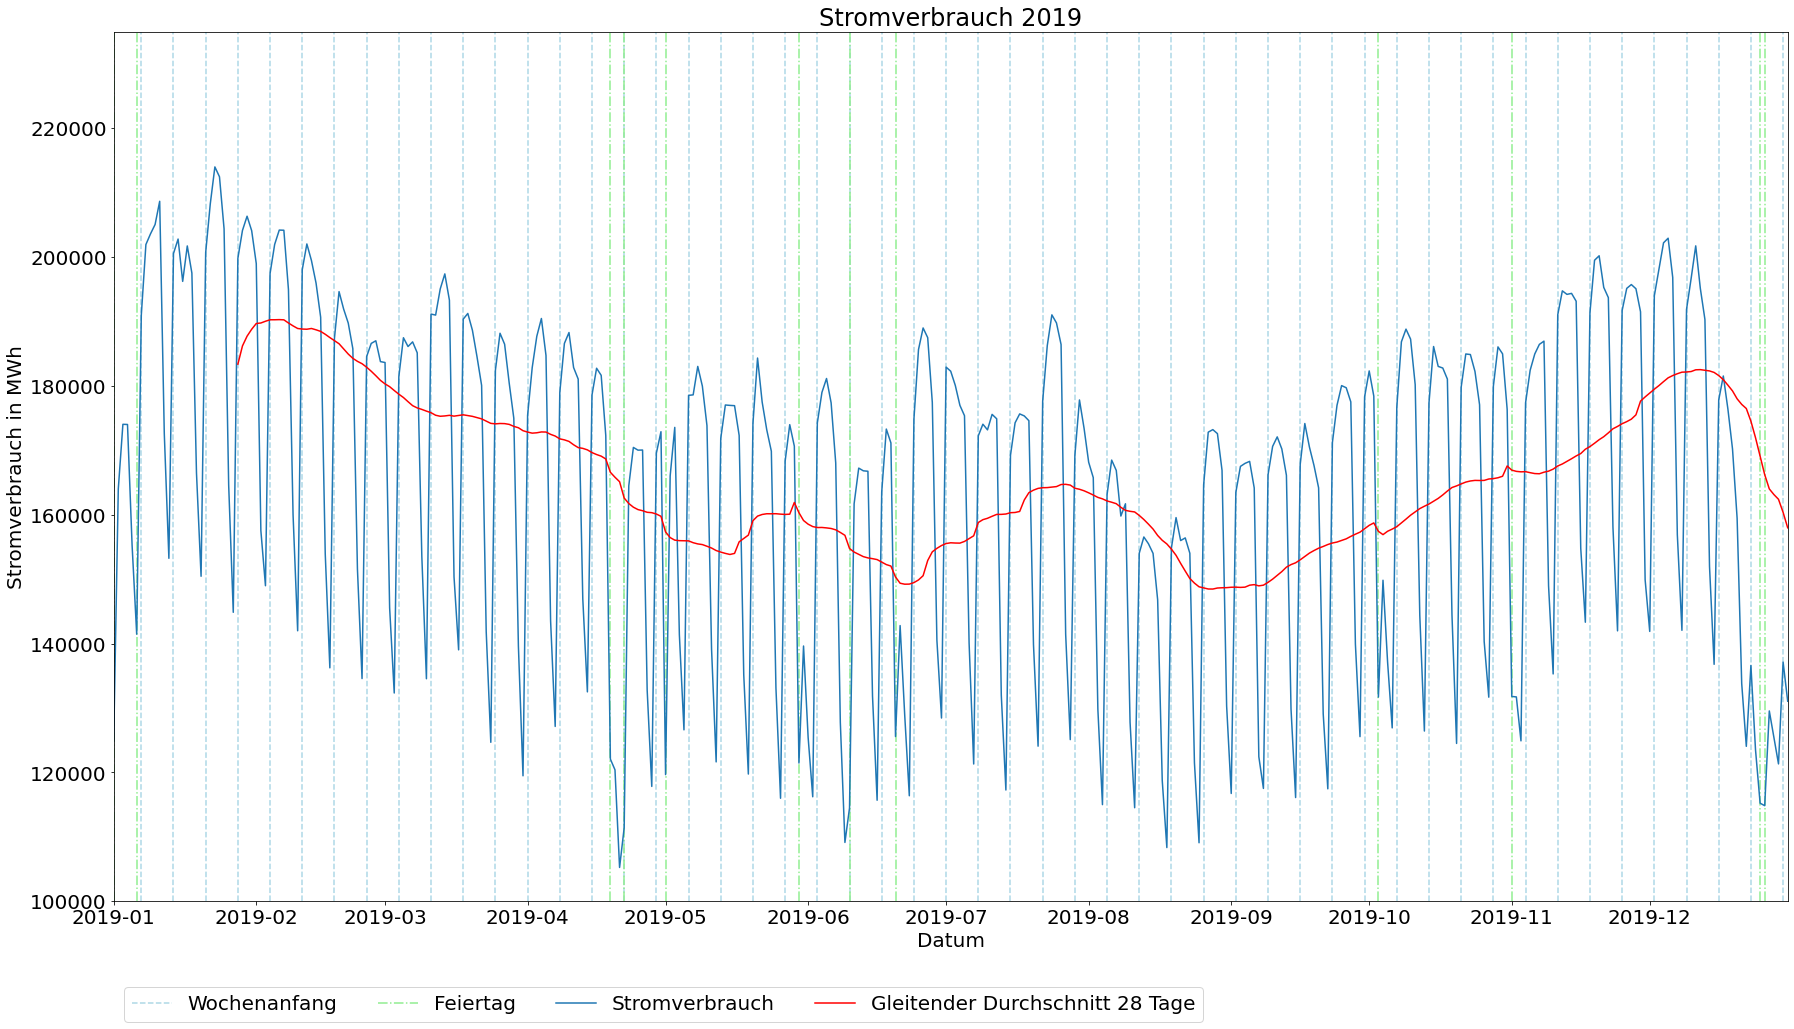

count       365.000000
mean     165227.328767
std       26466.914707
min      105260.000000
25%      141896.000000
50%      172606.000000
75%      185775.000000
max      213993.000000
Name: verbrauch, dtype: float64


 2020 -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------




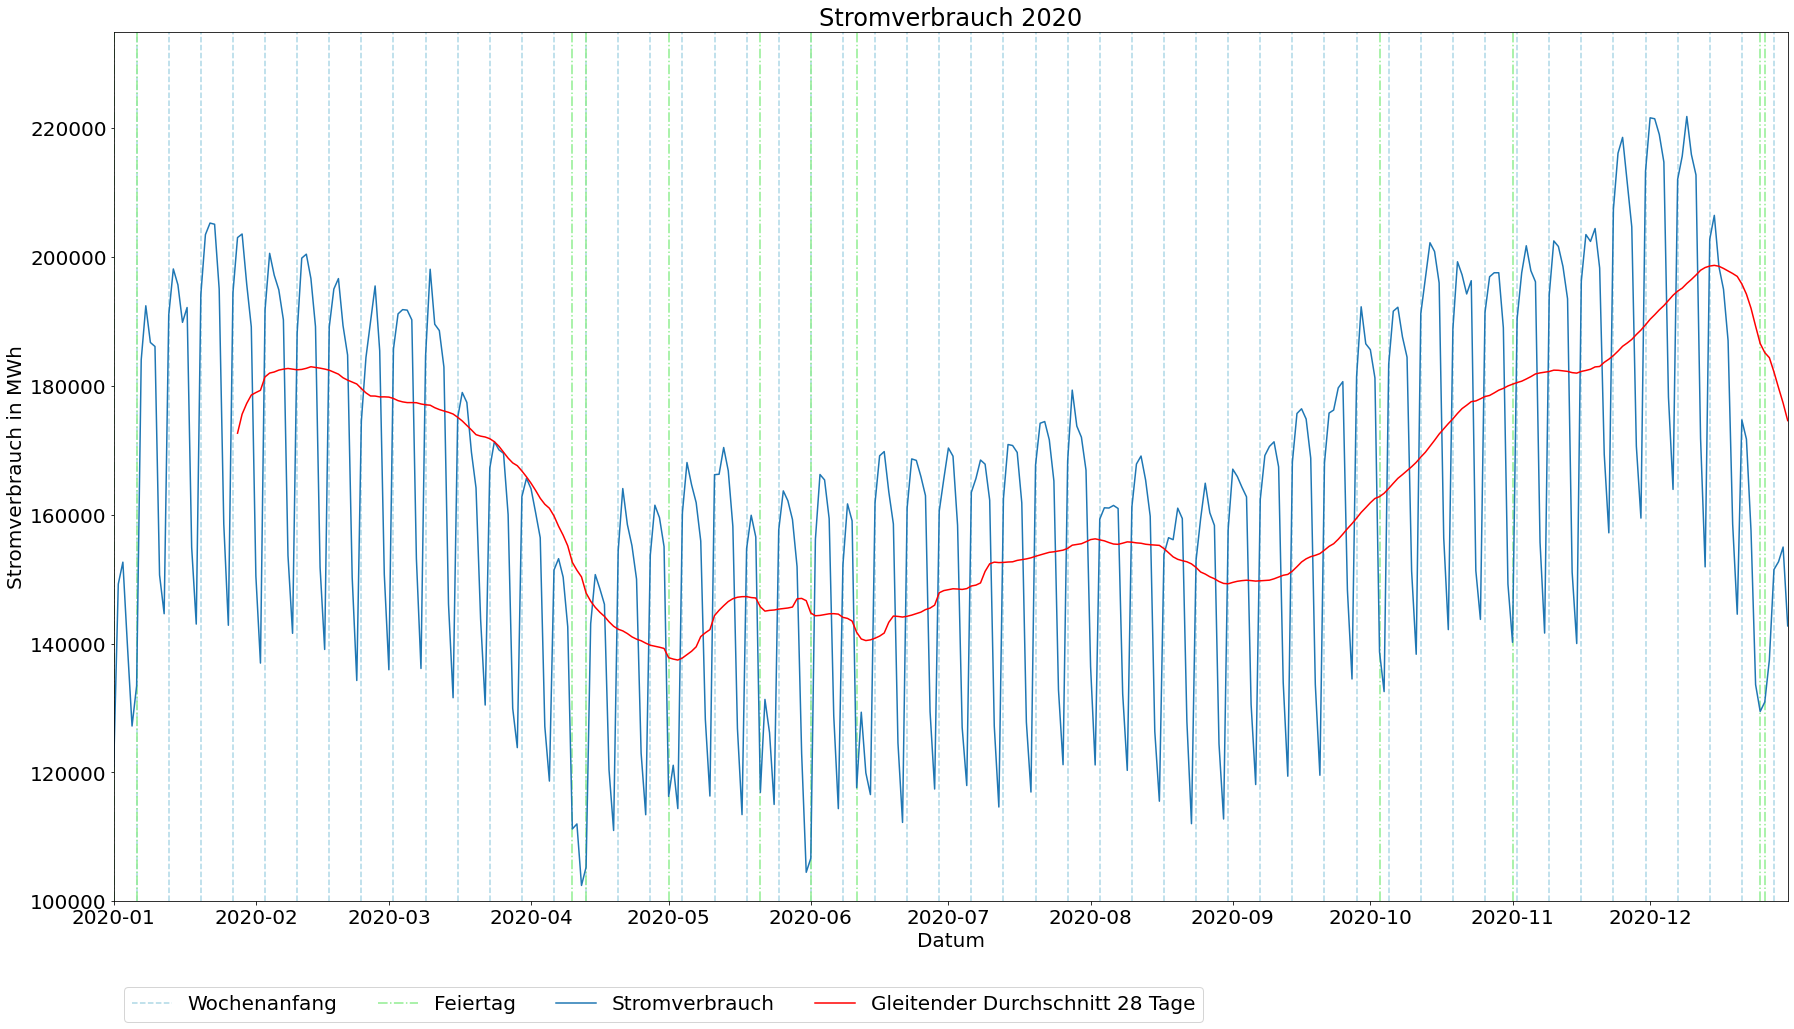

count       366.000000
mean     163535.265027
std       27571.683302
min      102469.000000
25%      144585.750000
50%      163529.500000
75%      187468.750000
max      221820.000000
Name: verbrauch, dtype: float64


 2021 -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------




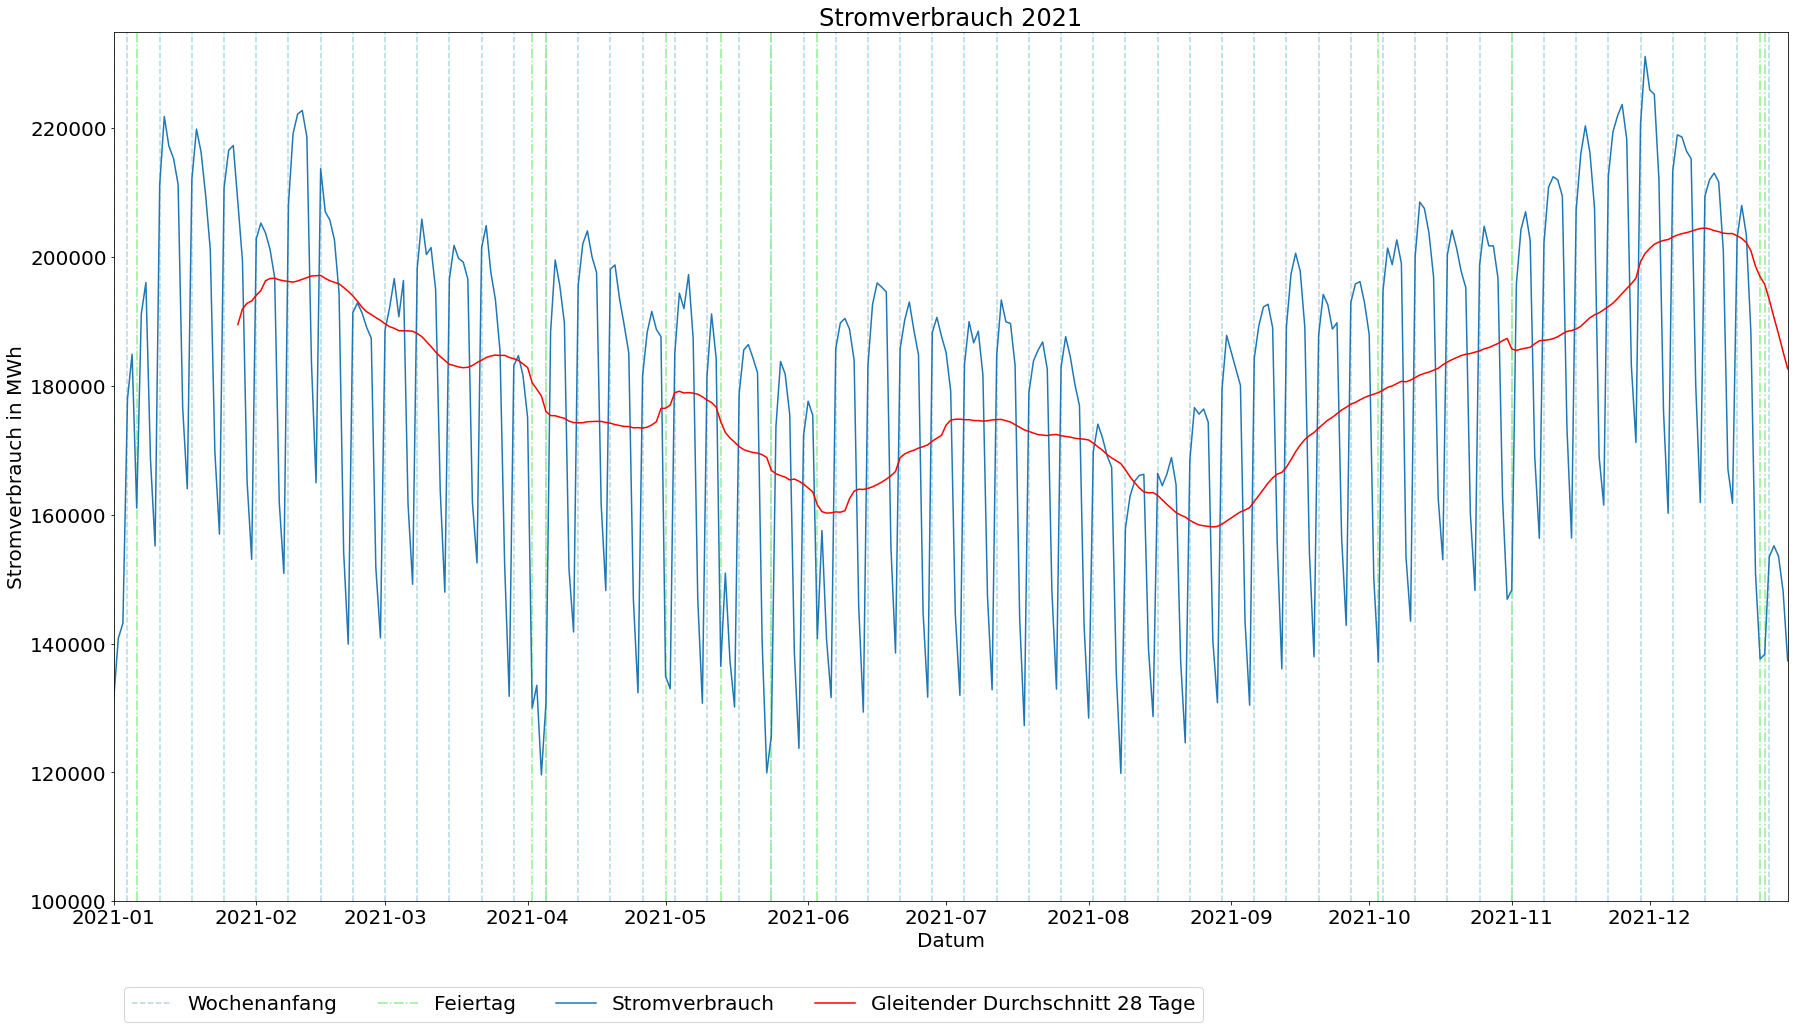

count       365.000000
mean     179215.739726
std       26419.478893
min      119636.000000
25%      157555.000000
50%      185453.000000
75%      198781.000000
max      231130.000000
Name: verbrauch, dtype: float64


In [5]:
for jahr in ["2015", "2016", "2017", "2018", "2019", "2020", "2021"]:
    
    print("\n\n", jahr, "-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n\n")
    
    #Obere und untere Datumsgrenze festlegen
    lower_border = jahr + "-01-01"
    upper_border = jahr + "-12-31"

    functions.draw_weeks(df[lower_border:upper_border])
    functions.draw_holiday(df[lower_border:upper_border])

    #Stromverbrauch plotten
    plt.plot(df[lower_border:upper_border]["verbrauch"], label="Stromverbrauch");
    plt.plot(df[lower_border:upper_border]["verbrauch"].rolling(window=28).mean(), color="red", label="Gleitender Durchschnitt 28 Tage")

    #Achsen und Layout
    plt.title("Stromverbrauch " + jahr)
    plt.ylabel("Stromverbrauch in MWh")
    plt.ylim(100000,235000)
    plt.xlabel("Datum")
    plt.xlim(dt.datetime(int(jahr), 1, 1), dt.datetime(int(jahr), 12, 31))

    #Legende einfügen
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.15), ncol=5)

    plt.show()
    
    print(df[lower_border:upper_border]["verbrauch"].describe())

<a class="anchor" id="2-01-stromverbrauch2021"></a>
<font size="5">
Dies ist bei genauerer Betrachtung (beispielsweise Anfang 2021) noch besser zu erkennen.
</font>

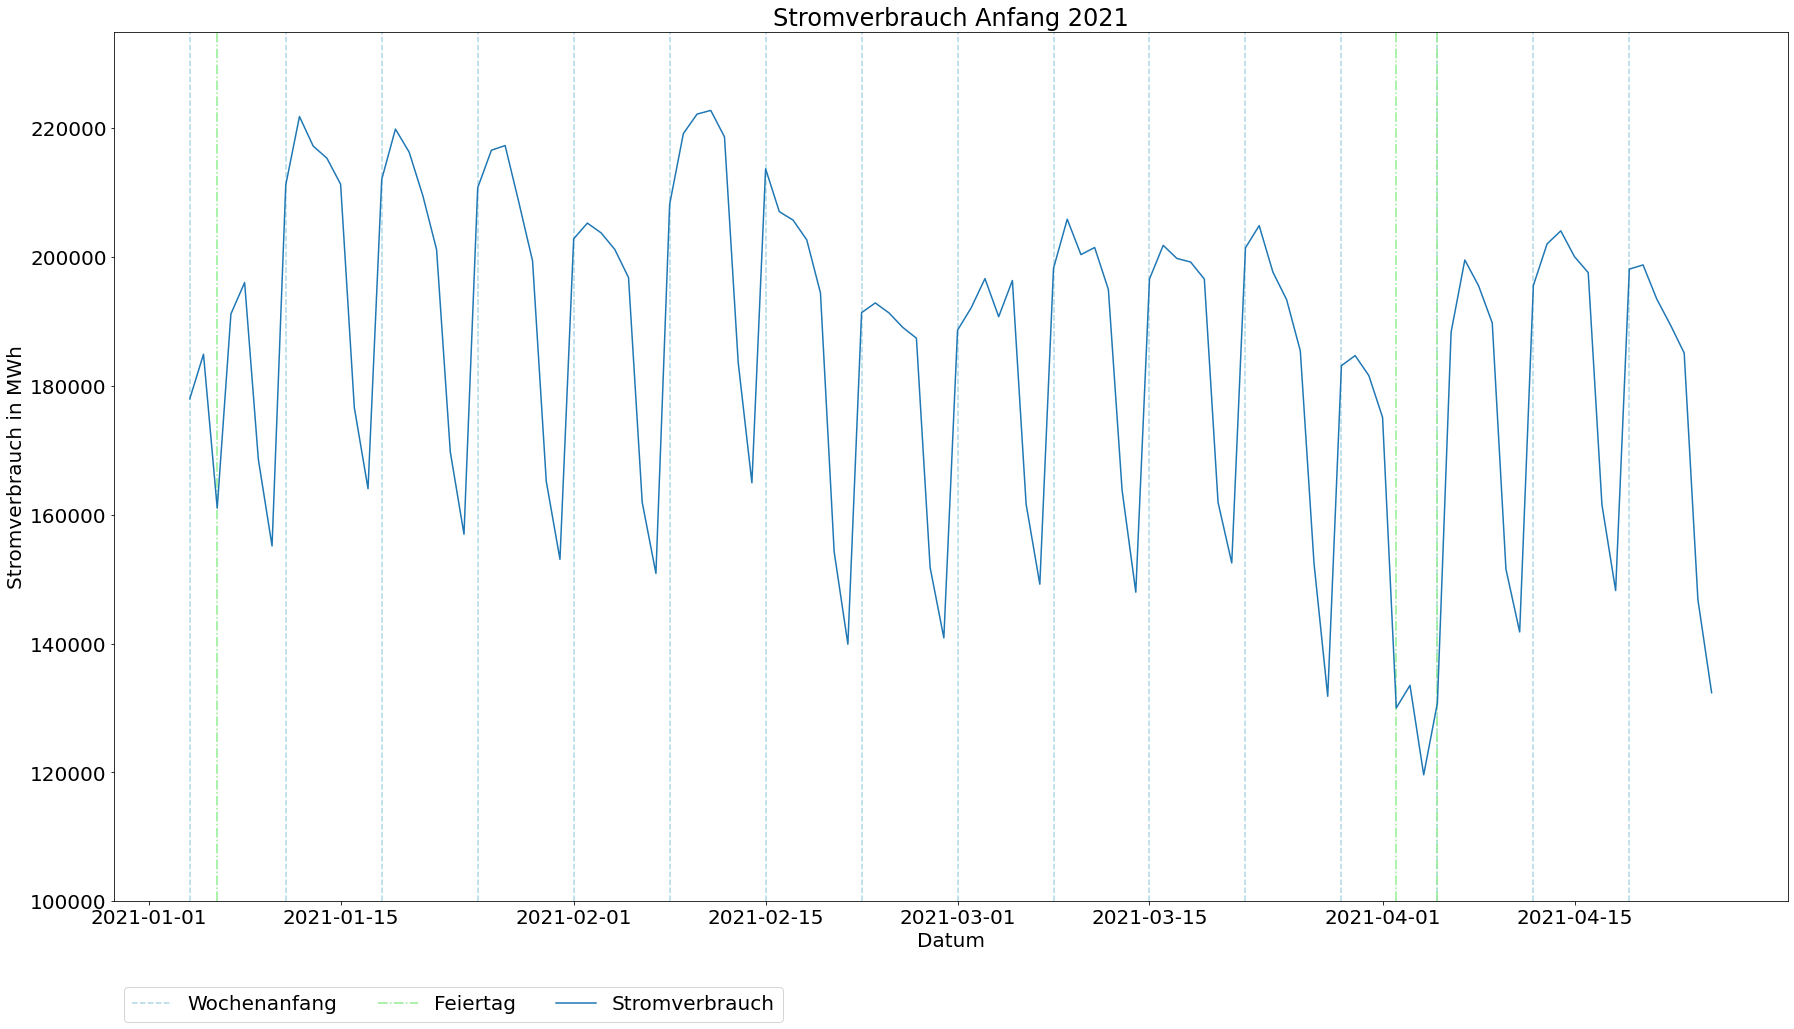

In [6]:
#Obere und untere Datumsgrenze festlegen
lower_border = "2021-01-04"
upper_border = "2021-04-25"

functions.draw_weeks(df[lower_border:upper_border])
functions.draw_holiday(df[lower_border:upper_border])

#Stromverbrauch plotten
plt.plot(df[lower_border:upper_border]["verbrauch"], label="Stromverbrauch");

#Achsen und Layout
plt.title("Stromverbrauch Anfang 2021")
plt.ylabel("Stromverbrauch in MWh")
plt.ylim(100000,235000)
plt.xlabel("Datum")

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.15), ncol=5)

plt.show()

## <font size="6">Stromverbrauch nach Monaten <a class="anchor" id="2-01-stromverbrauchnachmonaten"></a></font>

<font size="5">
Die Boxplots nach Monaten zeigen noch einmal die jährliche Saisonalität, welche bereits beschrieben wurde. Die Werte im Dezember folgen dem normalen Muster bis etwa zum 20. Dezember. Ab dann ist der Stromverbrauch aufgrund der Weihnachts- und Urlaubszeit außergewöhnlich niedrig, weshalb der Durchschnitt für den gesamten Monat relativ gering ist.
</font>

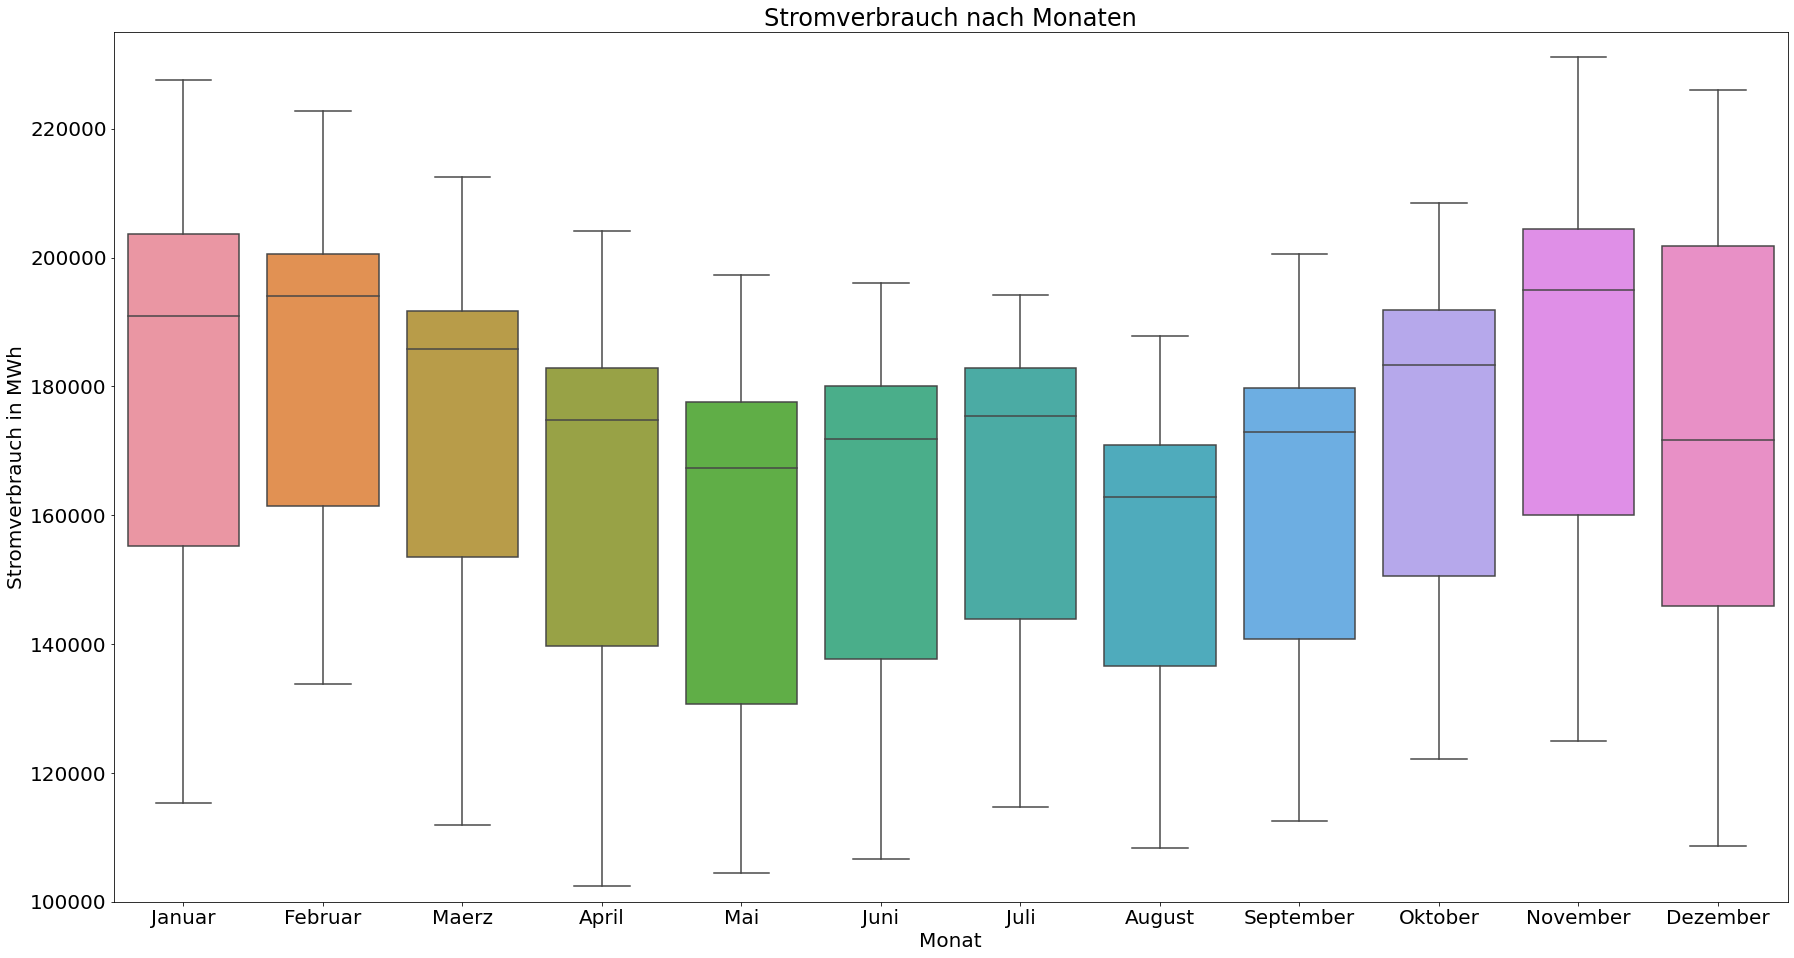

In [7]:
#Stromverbrauch plotten
sns.boxplot(data=df, x="monat", y="verbrauch")

#Achsen und Layout
plt.title("Stromverbrauch nach Monaten")
plt.ylabel("Stromverbrauch in MWh")
plt.ylim(100000,235000)
plt.xlabel("Monat")

plt.show()

## <font size="6"> Stromverbrauch nach Wochentagen <a class="anchor" id="2-01-stromverbrauchnachwochentagen"></a>

<font size="5">
Die Boxplots des Stromverbrauchs nach Wochentagen zeigen die bereits erwähnte wöchentliche Saisonalität. Der Stromverbrauch steigt von Montag bis Mittwoch und fällt dann zum Freitag hin ab. Samstags und besonders sonntags ist der Stromverbrauch dann signifikant niedriger als in der Woche.
</font>

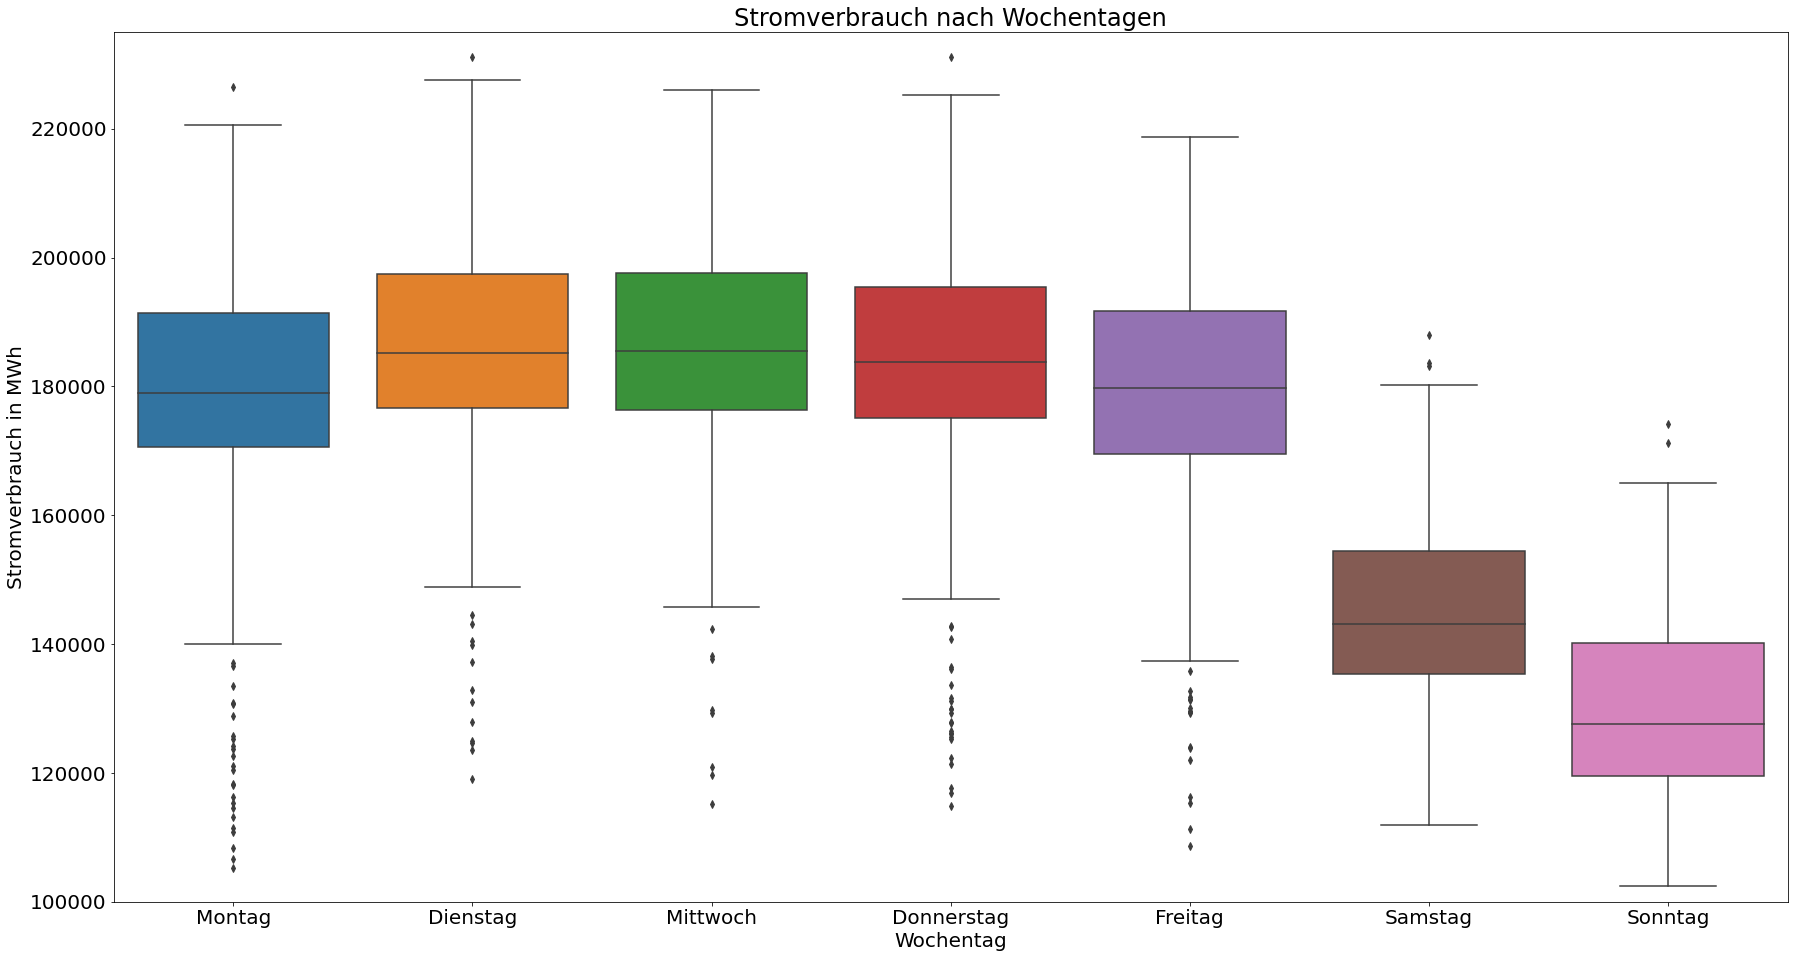

In [8]:
#Stromverbrauch plotten
sns.boxplot(data=df, x="wochentag", y="verbrauch", order=["Montag", "Dienstag", "Mittwoch", "Donnerstag", "Freitag", "Samstag", "Sonntag"])

#Achsen und Layout
plt.title("Stromverbrauch nach Wochentagen")
plt.ylabel("Stromverbrauch in MWh")
plt.ylim(100000,235000)
plt.xlabel("Wochentag")

plt.show()

<a class="anchor" id="2-01-stromverbrauchnachfeiertagen"></a>
<font size="5">
Bei Feiertagen spielt der Wochentag jedoch keine Rolle, da der Stromverbrauch an Feiertag mit circa 130.000 MWh stets besonders niedrig ist. Ein Unterschied zwischen den Wochentagen lässt sich nicht feststellen.
</font>

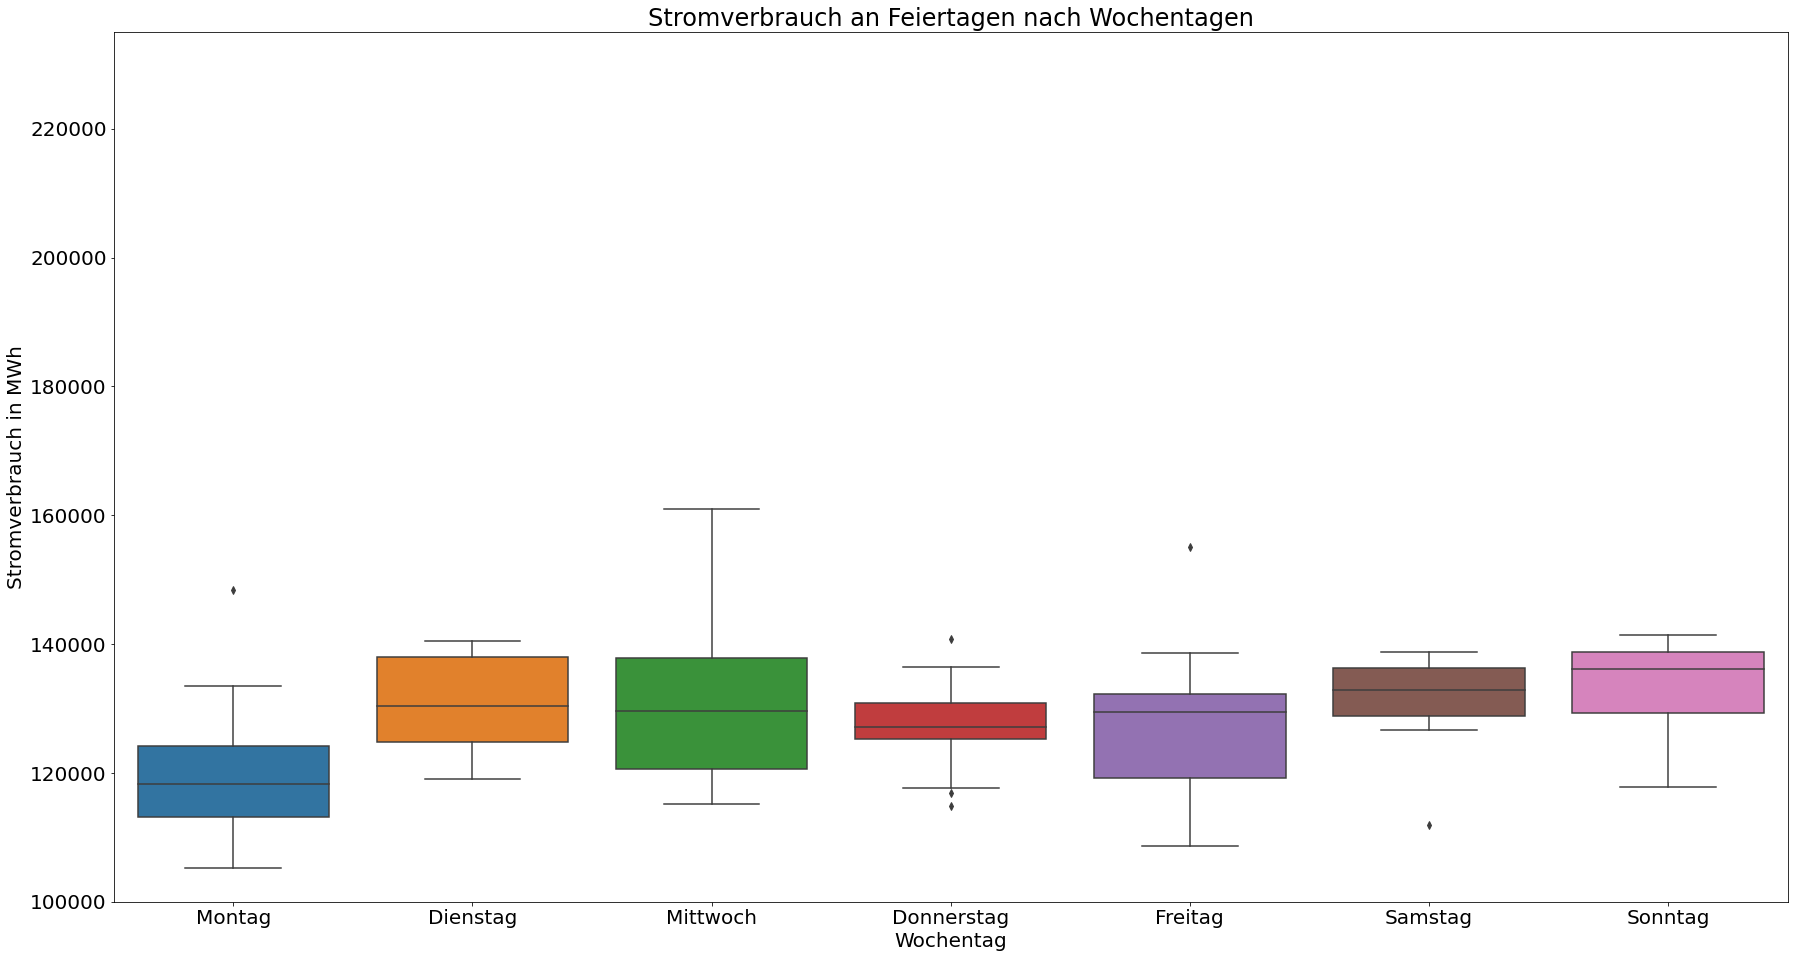

In [9]:
#Stromverbrauch plotten
sns.boxplot(data=df[df["feiertag"].isna() == False], x="wochentag", y="verbrauch", order=["Montag", "Dienstag", "Mittwoch", "Donnerstag", "Freitag", "Samstag", "Sonntag"])

#Achsen und Layout
plt.title("Stromverbrauch an Feiertagen nach Wochentagen")
plt.ylim(100000,235000)
plt.ylabel("Stromverbrauch in MWh")
plt.xlabel("Wochentag")

plt.show()

<a class="anchor" id="01-01-stromverbrauchnachfeiertagenjährlich"></a>
<font size="5">
Der Stromverbräuche an Samstagen, Sonntagen und Wochentagen unterscheidet sich zwar voneinander, die Unterschiede sind jedoch über das ganze Jahr konstant.
</font>

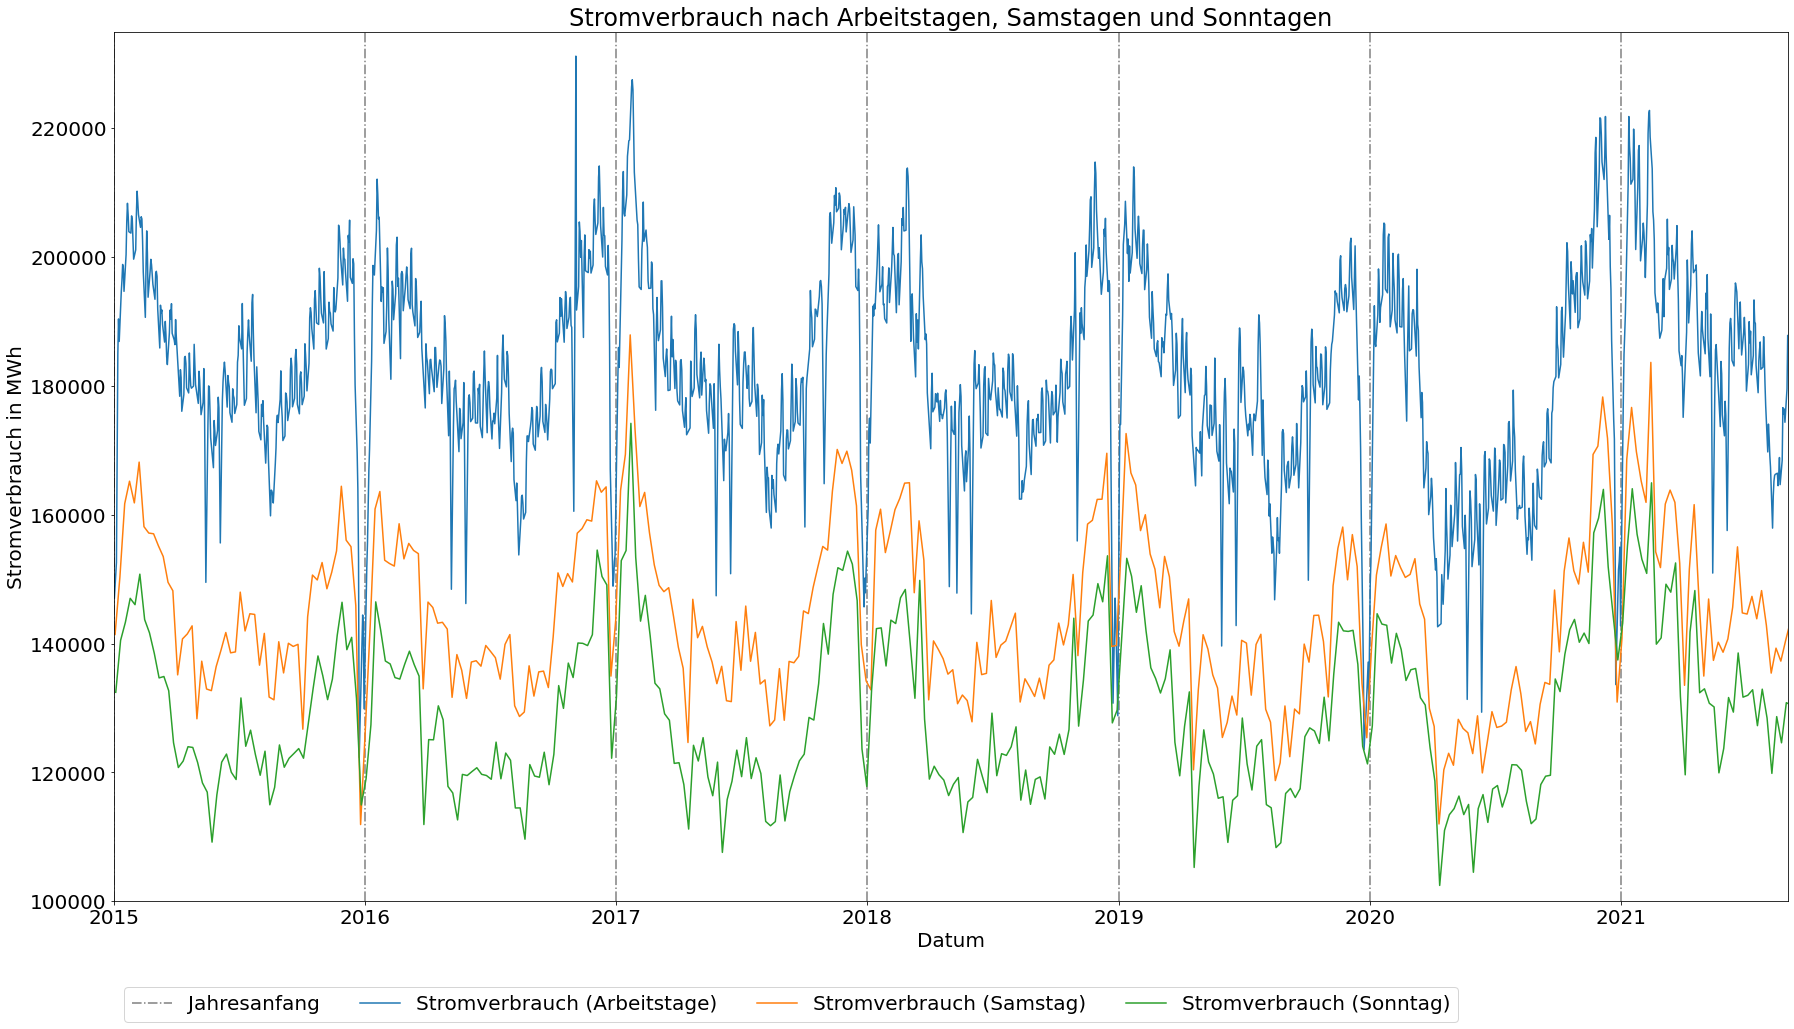

In [10]:
functions.draw_years(df)

#Stromverbräuche plotten
plt.plot(df[df["arbeitstag"] == 1]["verbrauch"], label="Stromverbrauch (Arbeitstage)");
plt.plot(df[df["wochentag"] == "Samstag"]["verbrauch"], label="Stromverbrauch (Samstag)");
plt.plot(df[df["wochentag"] == "Sonntag"]["verbrauch"], label="Stromverbrauch (Sonntag)");

#Achsen und Layout
plt.title("Stromverbrauch nach Arbeitstagen, Samstagen und Sonntagen")
plt.ylim(100000,235000)
plt.ylabel("Stromverbrauch in MWh")
plt.xlim(dt.datetime(2015,1,1), dt.datetime(2021,8,31))
plt.xlabel("Datum")

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.15), ncol=5)

plt.show()

# <font size="7"> Regressionanalyse <a class="anchor" id="01-01-regressionanalyse"></a></font>

<font size="5">Durch die Regressionsanalyse wird geprüft, inwieweit sich der Verlauf des Stromverbrauchs anhand der verfügbaren exogenen Merkmale modellieren lässt. Es geht dabei noch nicht um die Erstellung eines Vorhersagemodells. Stattdessen wird die Regressionsanalyse eher mit Blick auf potenzielle Zusammenhänge, Korrelationen und Muster beziehungsweise generelle Verläufe durchgeführt. Aus diesem Grund bietet sich eine Funktion sechsten Grades an. Dafür wird mit den Daten von 2015 bis 2018 und den entsprechenden Merkmalen eine Regression sechsten Grades durchgeführt, welche dann mit den Daten für 2019 getestet wird. Wie bereits erwähnt, gibt es 2020 und 2021 Abweichungen vom ansonsten üblichen Verlauf. Daher werden nur die Daten bis einschließlich 2019 verwendet.</font>

## <font size="6">Regression mit Arbeitstag <a class="anchor" id="2-01-regressionarbeitstag"></a></font>

<font size="5">Die Regression auf den Indikator für Arbeitstage zeigt, dass sich damit zumindest teilweise die wöchentliche Saisonalität abbilden lässt. Allerdings kann die jährliche Saisonalität nicht abgebildet werden.</font>

            arbeitstag  verbrauch
datum                            
2015-01-01           0     126197
2015-01-02           1     147085
2015-01-03           0     141426
2015-01-04           0     132446
2015-01-05           1     152611
...                ...        ...
2019-12-27           1     129551
2019-12-28           0     125395
2019-12-29           0     121331
2019-12-30           1     137130
2019-12-31           1     131060

[1826 rows x 2 columns]

       Vorhersage
R2            0.7
MAE       12114.5
MSE   237191722.1
RMSE      15401.0
                 
MAPE        7.8 %


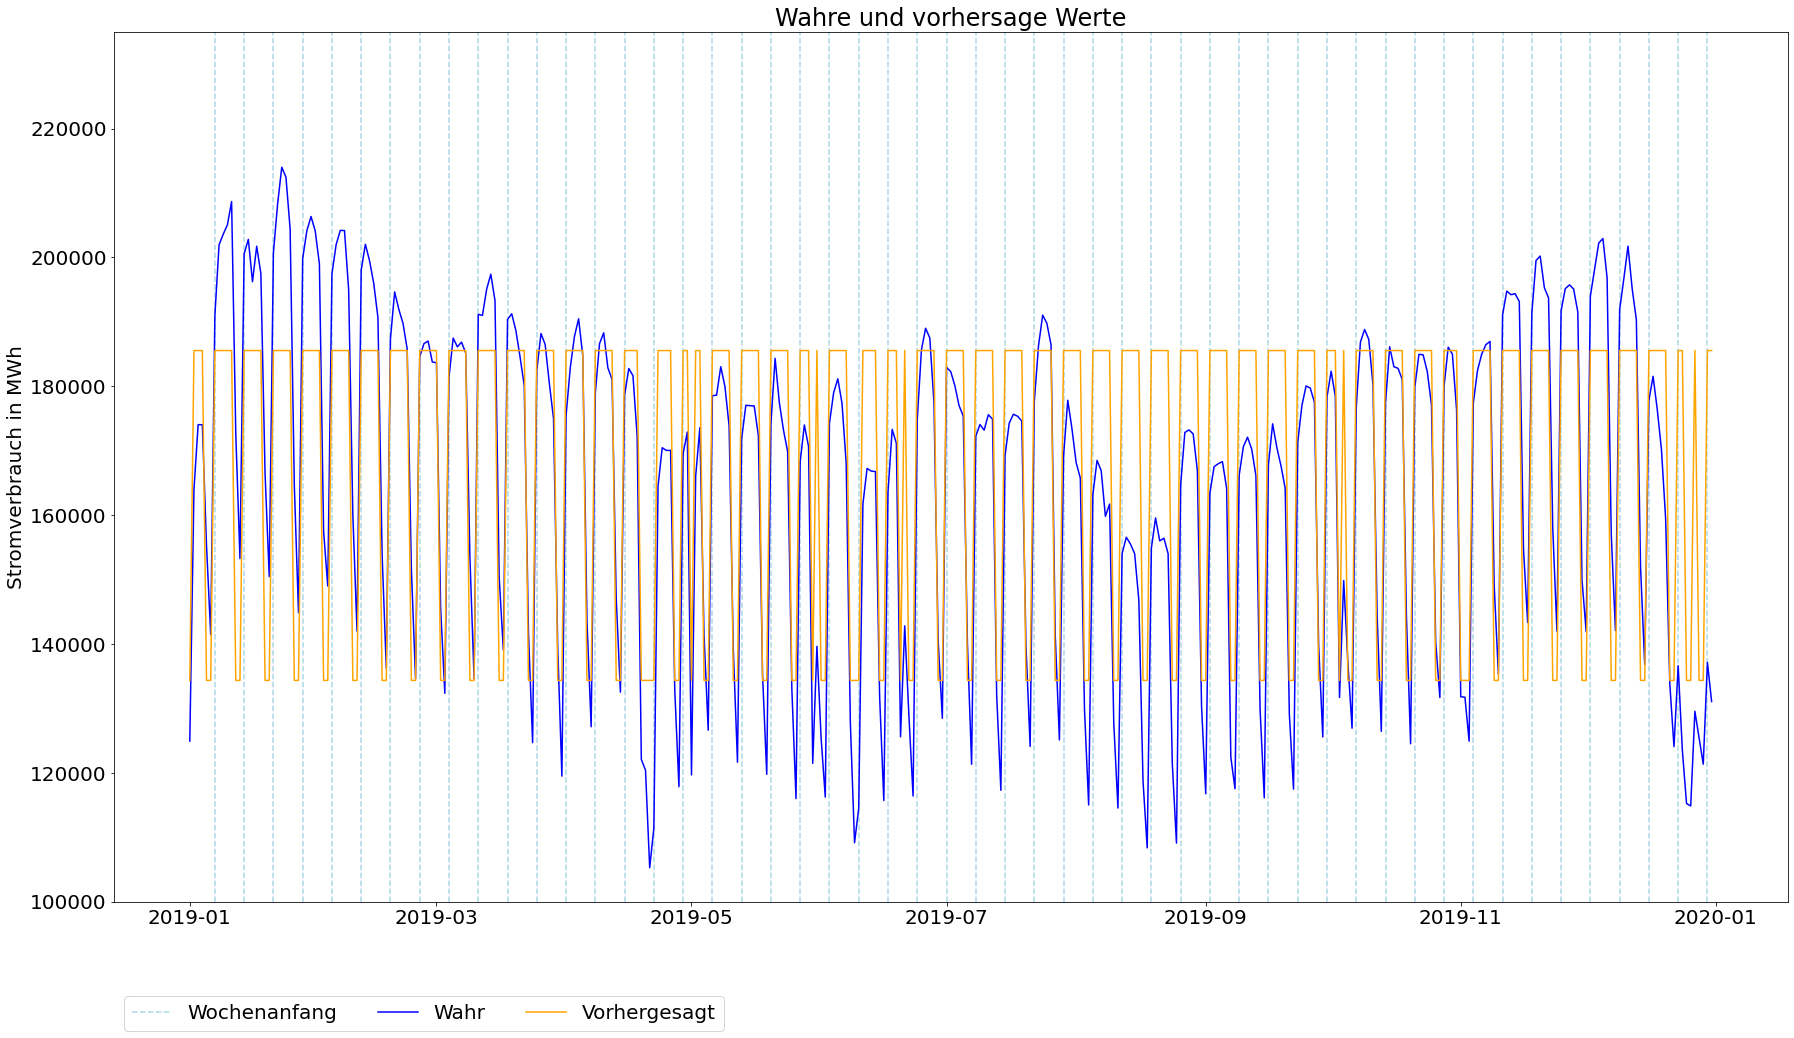

In [11]:
#Daten auswählen
df_regression = df[["arbeitstag", "verbrauch"]]
df_regression = df_regression["2015-01-01":"2019-12-31"]

print(df_regression)
print()

#Train-/Test-Split
train, test = functions.train_test_split(df_regression, 365)

#Polynomiale Regression sechsten Grades
pf = PolynomialFeatures(degree=6)
pf = pf.fit(df_regression[["arbeitstag"]].values.reshape(-1, 1))

y_train = train["verbrauch"]
y_test = test["verbrauch"]

X_train = pf.transform(train.drop(["verbrauch"], axis=1))
X_test = pf.transform(test.drop(["verbrauch"], axis=1))

#Regressionsmodel erstellen
model = LinearRegression().fit(X_train, y_train)

#Vorhersagen erstellen
preds = model.predict(X_test)
preds = pd.Series(data=preds, index=pd.date_range('01/01/2019', periods=365, freq='D')).rename("vorhergesagter verbrauch")

#Auswertung
functions.custom_metrics(y_test, preds)

## <font size="6">Regression mit Wochentagen <a class="anchor" id="01-01-regressionwochentagen"></a></font>

<font size="5">Da es sich bei den Wochentagen um ein nominales Merkmal handelt, wird es mittels One-Hot-Encoding in mehrere Indikatoren umgewandelt. Die Regression auf die Indikatoren für die jeweiligen Wochentage führt zu einem sehr ähnlichen Ergebnis wie bei den Arbeitstagen. Die wöchentliche Saisonalität kann hier besser abgebildet werden, allerdings lässt sich die jährliche Saisonalität immer noch nicht abbilden. Auch Feiertage werden schlechter abgebildet. Insgesamt ist der Unterschied zwischen der Regression auf die Wochentage und den Indikator für Arbeitstage trotzdem sehr ähnlich.</font>

            verbrauch  wochentag_Dienstag  wochentag_Donnerstag  wochentag_Freitag  wochentag_Mittwoch  wochentag_Montag  wochentag_Samstag  wochentag_Sonntag
datum                                                                                                                                                         
2015-01-01     126197                   0                     1                  0                   0                 0                  0                  0
2015-01-02     147085                   0                     0                  1                   0                 0                  0                  0
2015-01-03     141426                   0                     0                  0                   0                 0                  1                  0
2015-01-04     132446                   0                     0                  0                   0                 0                  0                  1
2015-01-05     152611                   0     

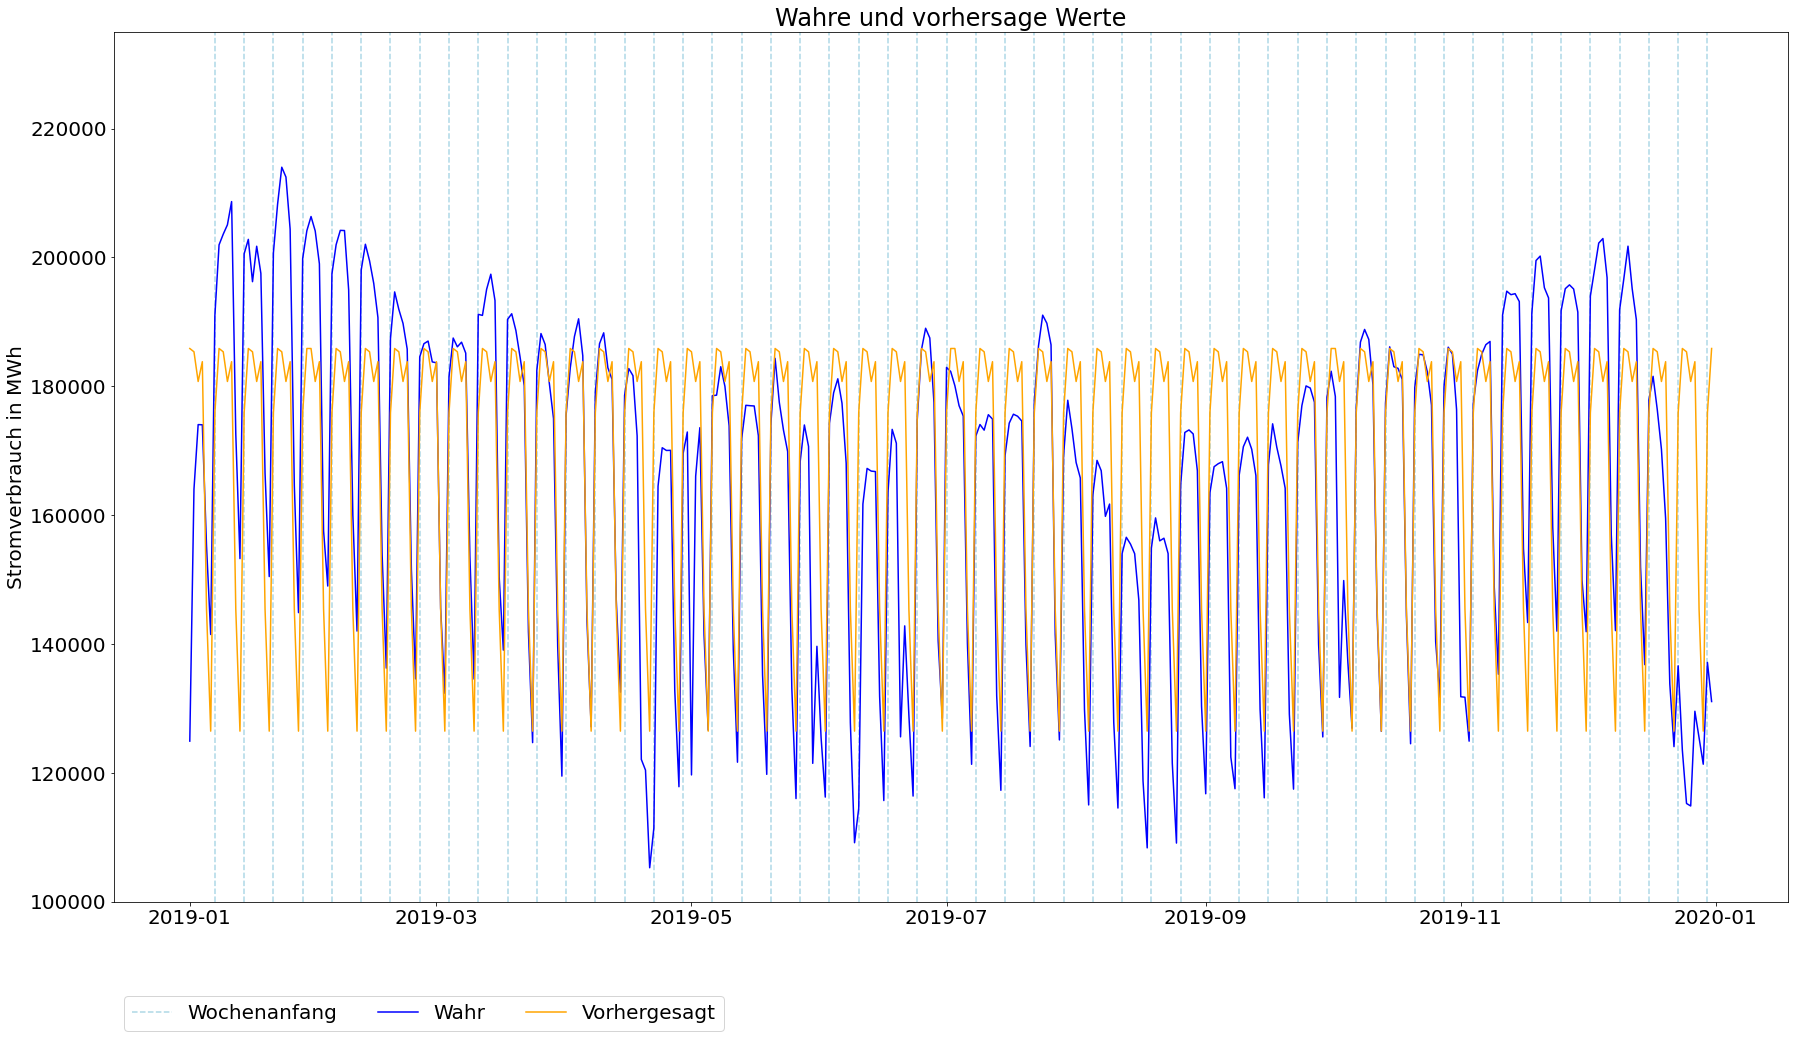

In [12]:
#Daten auswählen
df_regression = df[["wochentag", "verbrauch"]]
df_regression = pd.get_dummies(df_regression, columns=["wochentag"])
df_regression = df_regression["2015-01-01":"2019-12-31"]

print(df_regression)

#Train-/Test-Split
train, test = functions.train_test_split(df_regression, 365)

#Polynomiale Regression sechsten Grades
pf = PolynomialFeatures(degree=6)
pf = pf.fit(df_regression[["wochentag_Montag", "wochentag_Dienstag", "wochentag_Mittwoch", "wochentag_Donnerstag", "wochentag_Freitag", "wochentag_Samstag", "wochentag_Sonntag"]].values.reshape(-7, 7))

y_train = train["verbrauch"]
y_test = test["verbrauch"]

X_train = pf.transform(train.drop(["verbrauch"], axis=1))
X_test = pf.transform(test.drop(["verbrauch"], axis=1))

#Regressionsmodel erstellen
model = LinearRegression().fit(X_train, y_train)

#Vorhersagen erstellen
preds = model.predict(X_test)
preds = pd.Series(data=preds, index=pd.date_range('01/01/2019', periods=365, freq='D')).rename("vorhergesagter verbrauch")

#Auswertung
functions.custom_metrics(y_test, preds)

## <font size="6">Regression mit Wochentag und Abeitstag <a class="anchor" id="01-01-regressionwochentagarbeitstag"></a></font>

<font size="5">Dies bestätigt sich auch bei der Regression auf Wochentage und den Indikator für Arbeitstage, da sich hierdurch keine beziehungsweise nur minimale Verbesserungen im Vergleich zu den Modellen mit je nur einem Merkmal erkennen lassen.</font>

            arbeitstag  verbrauch  wochentag_Dienstag  wochentag_Donnerstag  wochentag_Freitag  wochentag_Mittwoch  wochentag_Montag  wochentag_Samstag  wochentag_Sonntag
datum                                                                                                                                                                     
2015-01-01           0     126197                   0                     1                  0                   0                 0                  0                  0
2015-01-02           1     147085                   0                     0                  1                   0                 0                  0                  0
2015-01-03           0     141426                   0                     0                  0                   0                 0                  1                  0
2015-01-04           0     132446                   0                     0                  0                   0                 0             

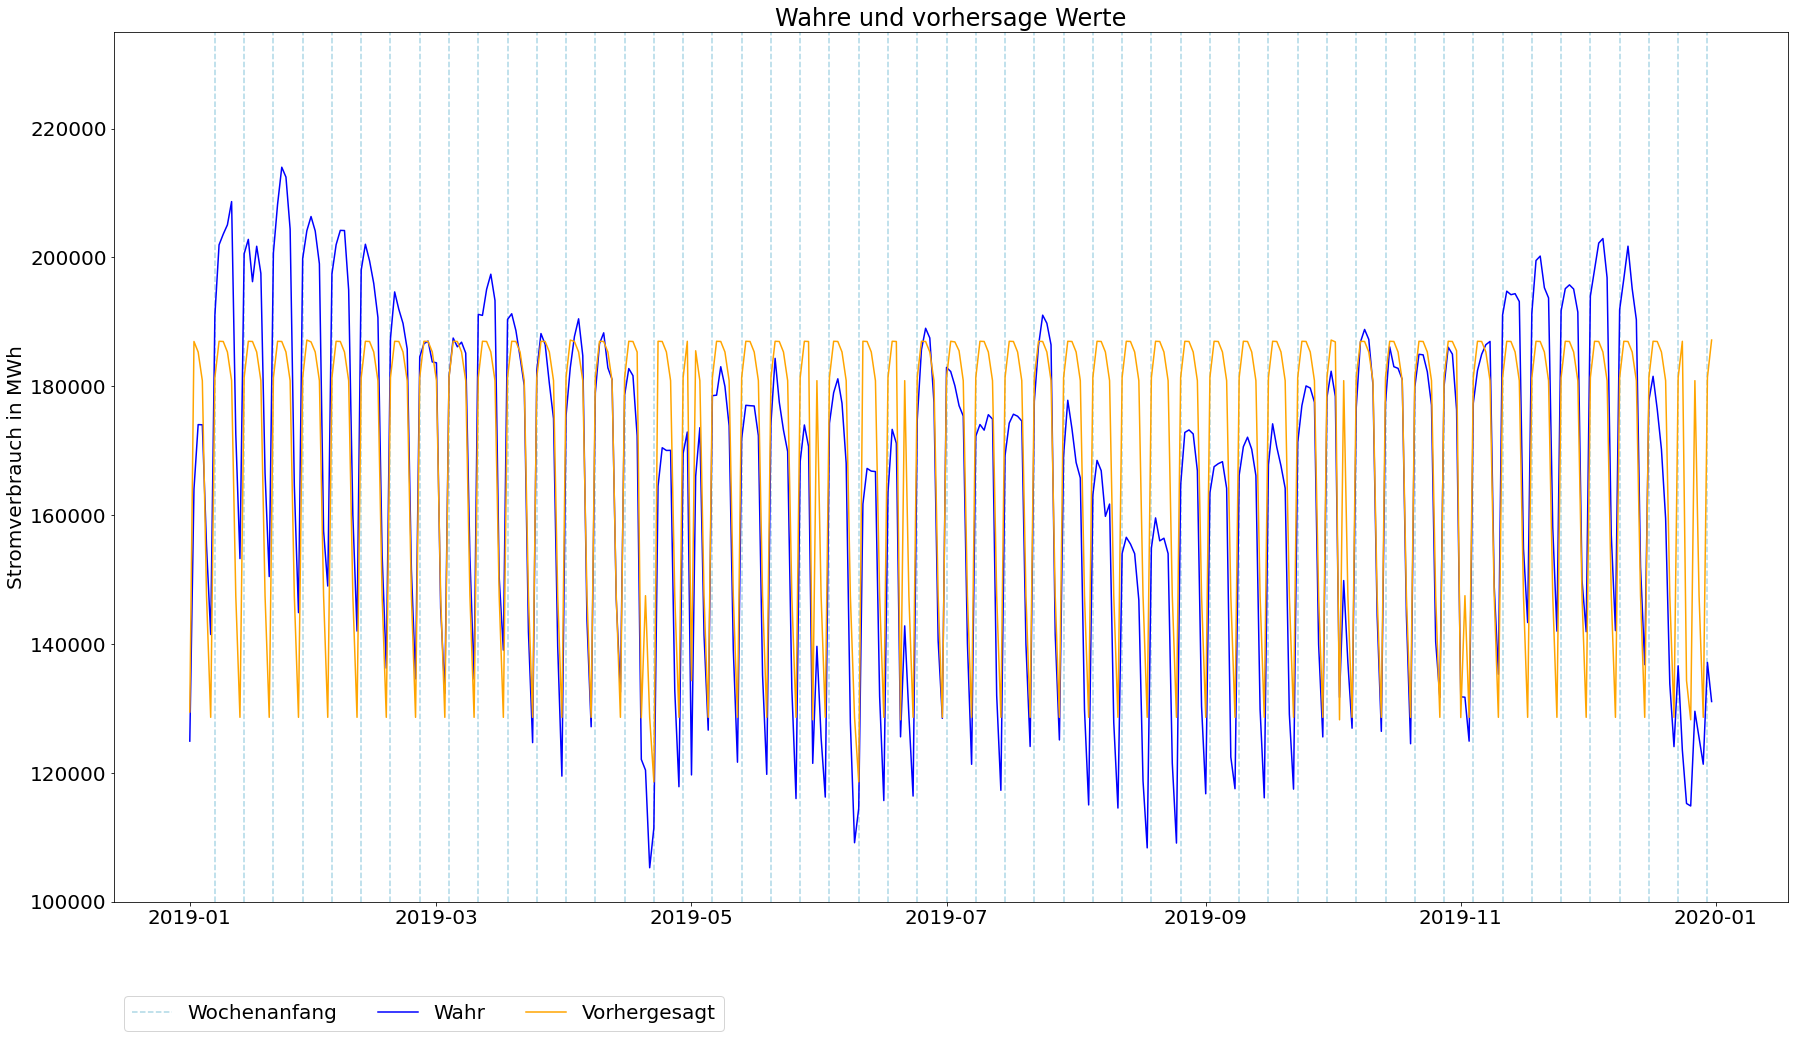

In [13]:
#Daten auswählen
df_regression = df[["wochentag", "arbeitstag", "verbrauch"]]
df_regression = pd.get_dummies(df_regression, columns=["wochentag"])
df_regression = df_regression["2015-01-01":"2019-12-31"]

print(df_regression)

#Train-/Test-Split
train, test = functions.train_test_split(df_regression, 365)

#Polynomiale Regression sechsten Grades
pf = PolynomialFeatures(degree=6)
pf = pf.fit(df_regression[["wochentag_Montag", "wochentag_Dienstag", "wochentag_Mittwoch", "wochentag_Donnerstag", "wochentag_Freitag", "wochentag_Samstag", "wochentag_Sonntag", "arbeitstag"]].values.reshape(-8, 8))

y_train = train["verbrauch"]
y_test = test["verbrauch"]

X_train = pf.transform(train.drop(["verbrauch"], axis=1))
X_test = pf.transform(test.drop(["verbrauch"], axis=1))

#Regressionsmodel erstellen
model = LinearRegression().fit(X_train, y_train)

#Vorhersagen erstellen
preds = model.predict(X_test)
preds = pd.Series(data=preds, index=pd.date_range('01/01/2019', periods=365, freq='D')).rename("vorhergesagter verbrauch")

#Auswertung
functions.custom_metrics(y_test, preds)

# <font size="7">Zeitreihenanalyse <a class="anchor" id="01-01-zeitreihenanalyse"></a></font>

<font size="5">Bei der Zeitreihenanalyse wird der Stromverbrauch auf zeitreihen-typische Eigenschaften (wie Saisonalitäten, Stationarität, Autokorrelationen) untersucht.</font>

## <font size="6">Dekomposition <a class="anchor" id="01-01-dekomposition"></a></font>

<font size="5">Die Dekomposition teilt die Zeitreihe in Trend, Saisonalität und Residuen mit einer wöchentlichen Saisonalität der Länge 7 auf. Die meisten Residuen bewegen sich im Bereich von etwa -10.000 bis +15.000 und haben daher einen geringen Anteil an der Zeitreihe. Die besonders großen Residuen sind vermutlich auf Feiertage mit starken Abweichungen vom "normalen" Verbrauch zurückzufühen. Die Saisonalität reicht von etwa -40.000 bis +20.000 und hat damit einen weitaus größeren Anteil an der Zeitreihe als die Residuen. Der Trend kann von der Funktion nicht richtig erkannt werden und entspricht hier eher der jährlichen Saisonalität.</font>

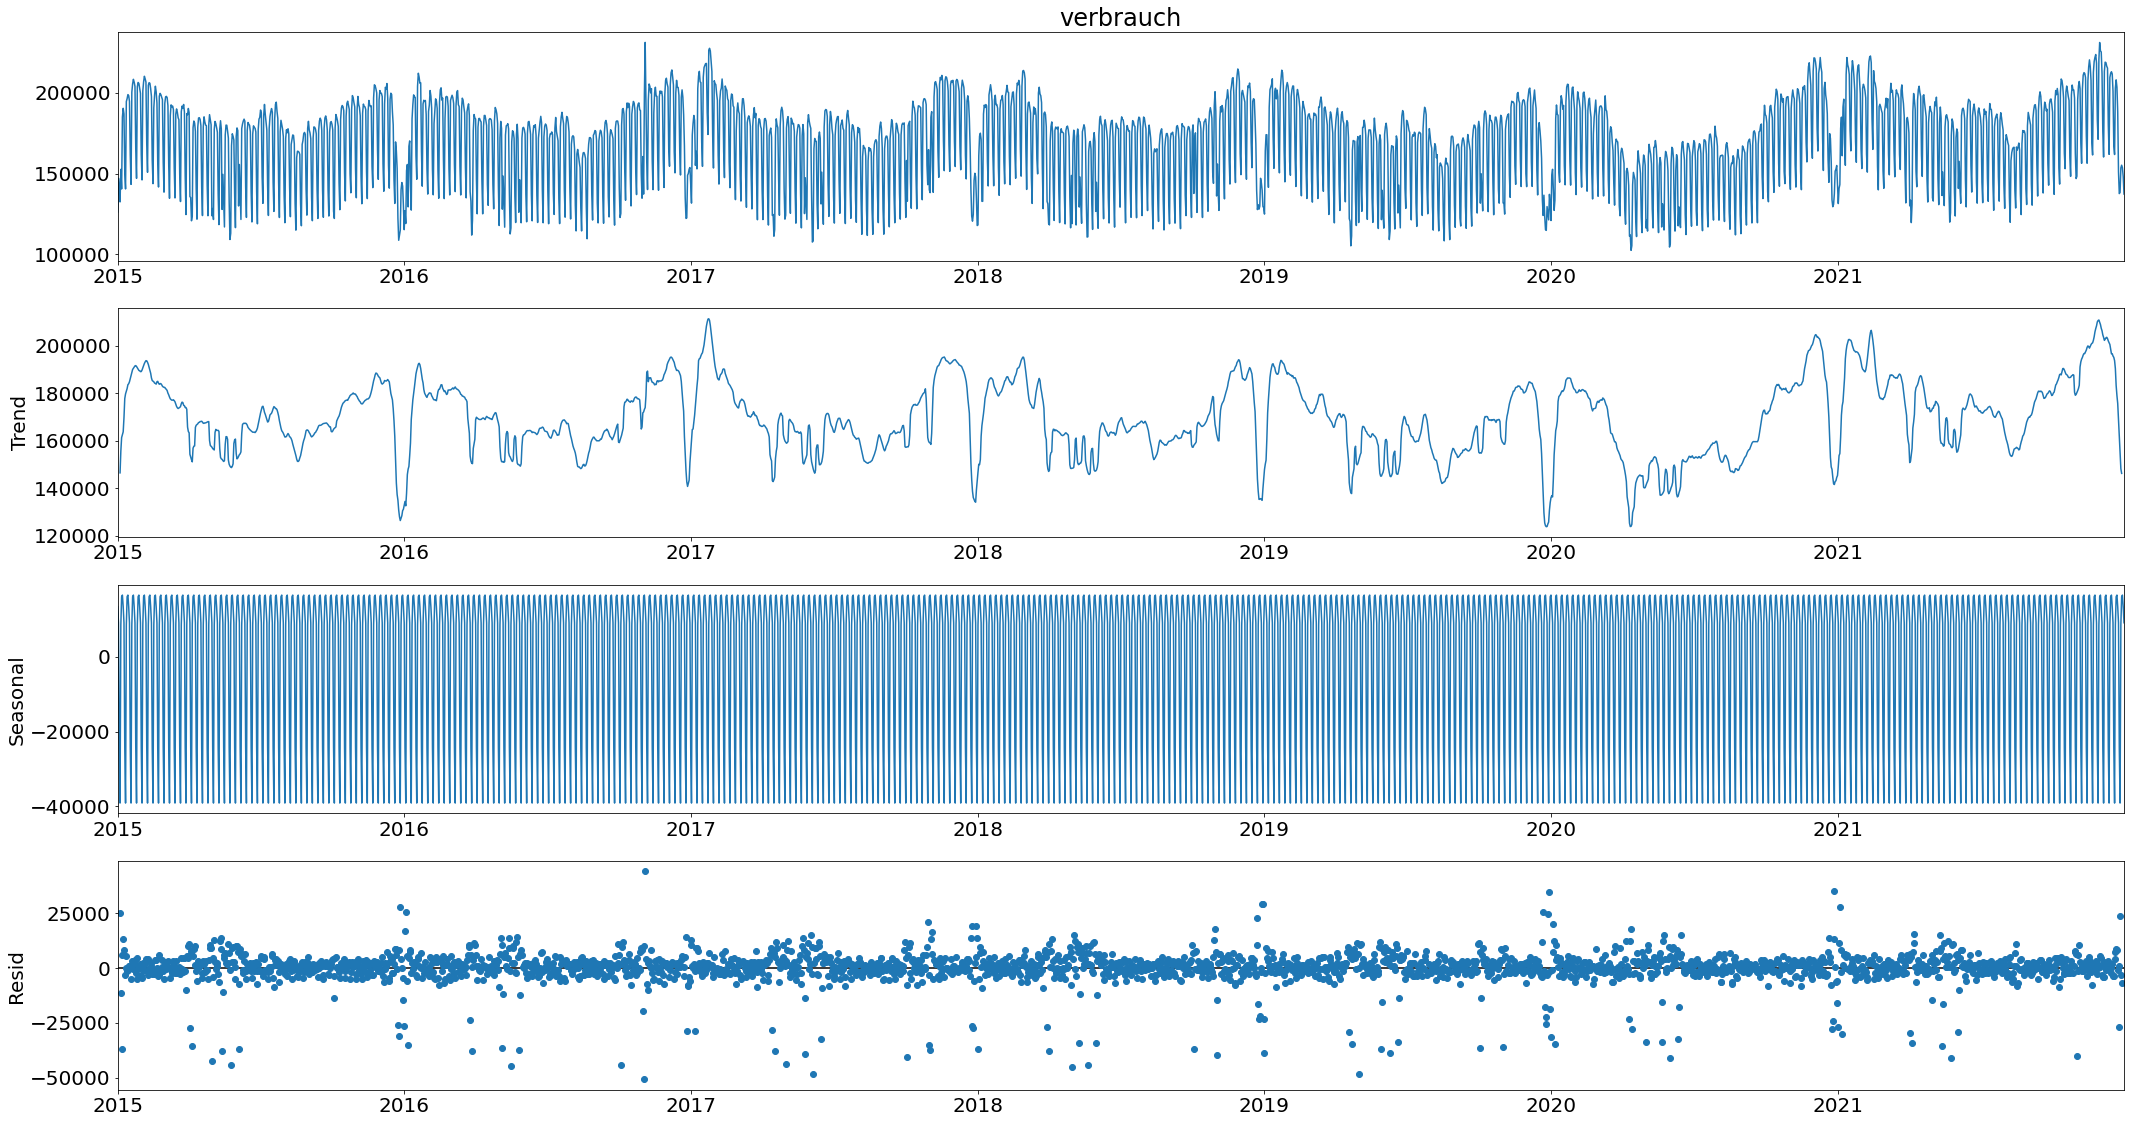

In [14]:
results = seasonal_decompose(x=df["verbrauch"], period=7)
results.plot();

<font size="5">Wird eine jährliche Saisonalität der Länge 365 ausgwewählt, wird der Trend wesentlich besser erkannt. Er bewegt sich stabil, fällt allerdings 2020 stark ab und steigt 2021 dann sehr stark an. Es handelt sich dabei um die Einflüsse durch die Coronavirus-Pandemie. Aufgrund der ihrer Länge kann die Saisonalität (und in Verbindung damit die Residuen ebenfalls) nicht mehr richtig erkannt werden.</font>

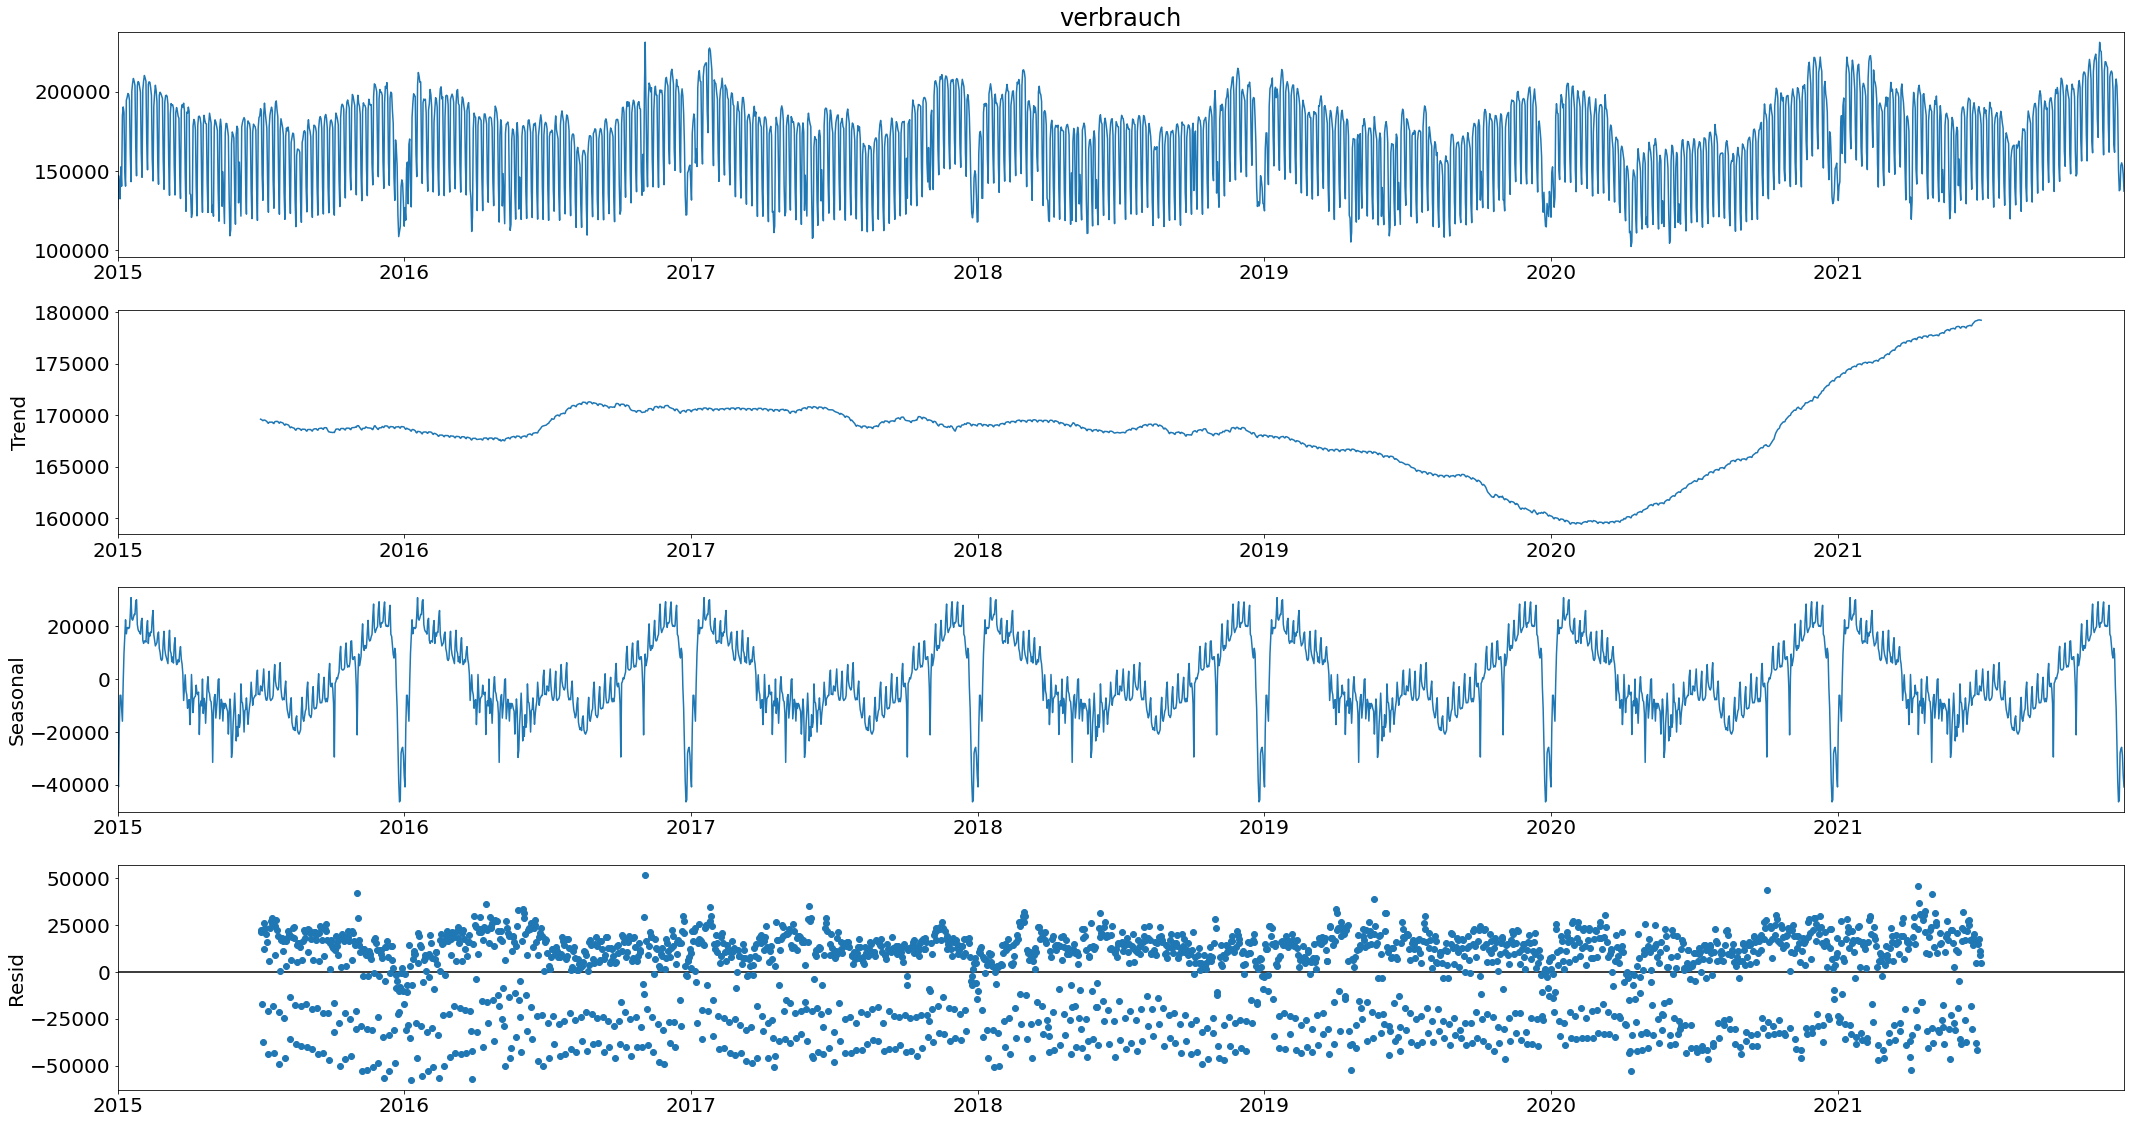

In [15]:
results = seasonal_decompose(x=df["verbrauch"], period=365)
results.plot();

## <font size="6">Stationarität <a class="anchor" id="2-01-stationarität"></a></font>

<font size="5">Sowohl ADF- und KPSS-Test ergeben, dass es sich um eine stationäre Zeitreihe handelt.</font>

In [16]:
print("Ergebnisse des ADF-Test:")
dftest = adfuller(df["verbrauch"], autolag="AIC")
dfoutput = pd.Series(
    dftest[0:4],
    index=[
        "Test-Statistik",
        "p-Wert",
        "#Lags verwendet",
        "Anzahl verwendeter Beobachtungen",
    ],
)
for key, value in dftest[4].items():
    dfoutput["Critical Value (%s)" % key] = value
print(dfoutput)

if dftest[1] <= 0.05: print("Nullhypothese wird verworfen, Daten sind stationär")
else: print("Nullhypothese wird beibehalten, Daten sind nicht stationär")

Ergebnisse des ADF-Test:
Test-Statistik                        -5.211151
p-Wert                                 0.000008
#Lags verwendet                       27.000000
Anzahl verwendeter Beobachtungen    2529.000000
Critical Value (1%)                   -3.432938
Critical Value (5%)                   -2.862684
Critical Value (10%)                  -2.567379
dtype: float64
Nullhypothese wird verworfen, Daten sind stationär


In [17]:
print("Ergebnisse des KPSS-Test:")
kpsstest = kpss(df["verbrauch"], regression="c", nlags="auto")
kpss_output = pd.Series(
    kpsstest[0:3], index=["Teststatistik", "p-Wert", "Verwendete Lags"]
)
for key, value in kpsstest[3].items():
    kpss_output["Critical Value (%s)" % key] = value
print(kpss_output)

if kpsstest[1] <= 0.05: print("Nullhypothese wird verworfen, Daten sind nicht stationär")
else: print("Nullhypothese wird beibehalten, Daten sind stationär")

Ergebnisse des KPSS-Test:
Teststatistik             0.325023
p-Wert                    0.100000
Verwendete Lags          13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Nullhypothese wird beibehalten, Daten sind stationär


## <font size="6">Einfache Autokorrelation <a class="anchor" id="2-01-autokorrelation"></a></font>

<font size="5">Die wöchtentliche Saisonalität spiegelt sich besonders in der einfachen Autokorrelation wieder. Sie ist bei jedem siebten Lag besonders hoch, das Niveau nimmt allerdings bis zum 180 Lag (Jahresmitte) ab und steigt dann wieder an.</font>

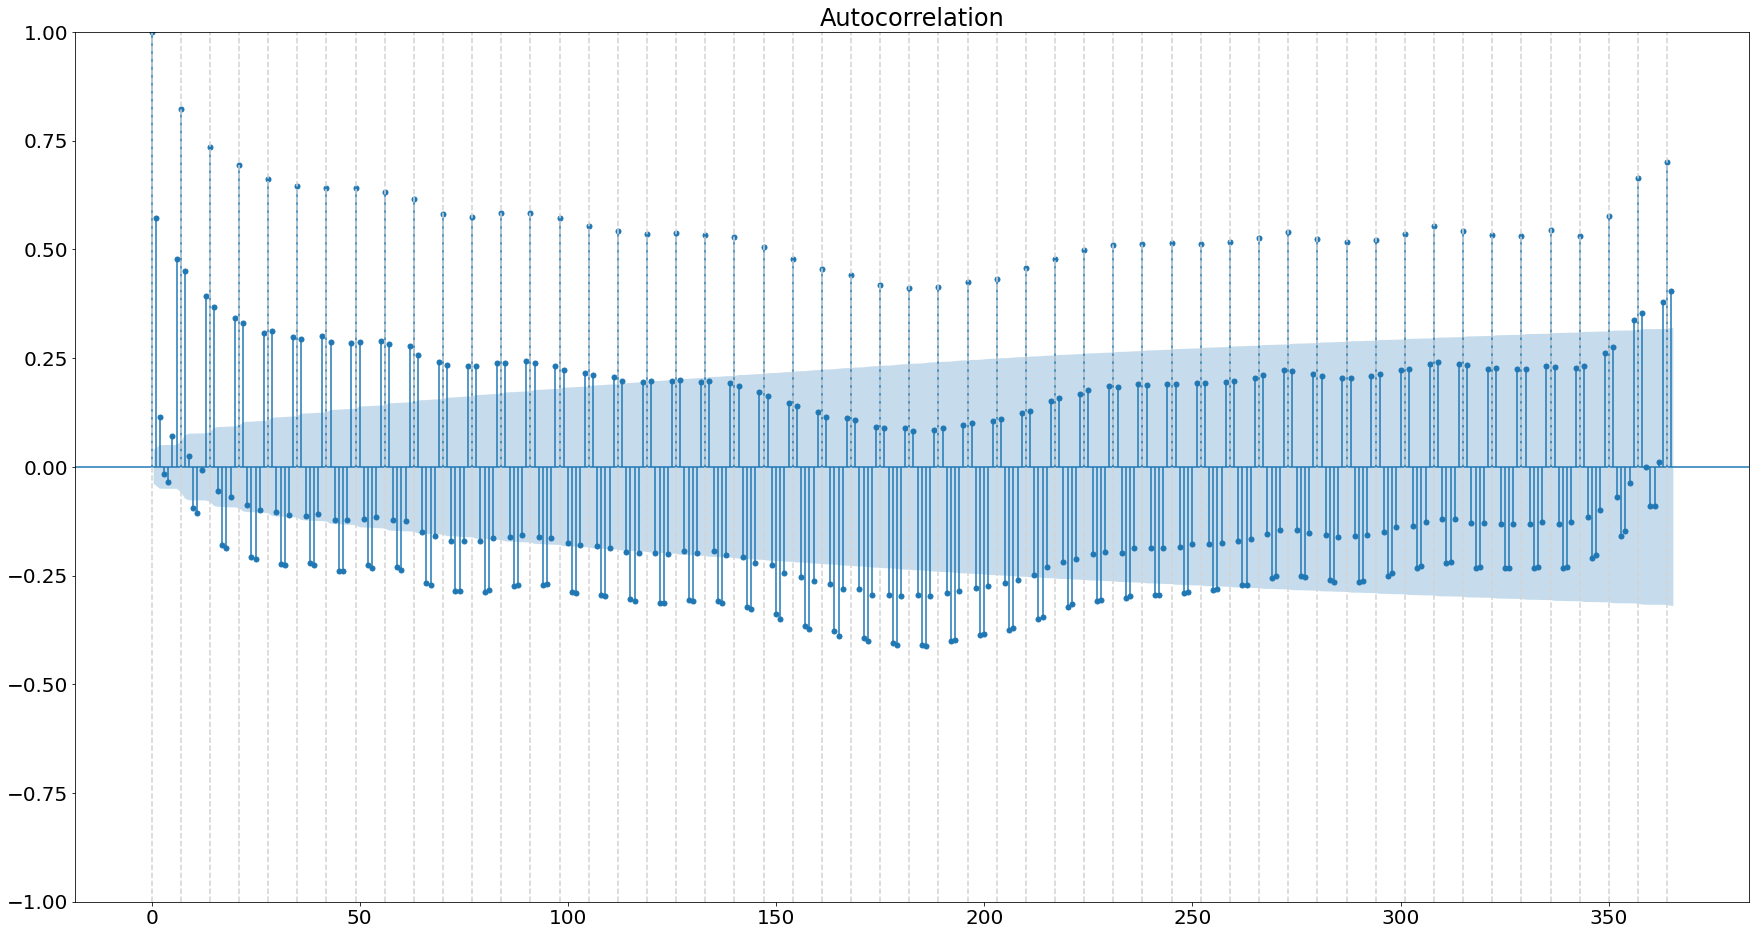

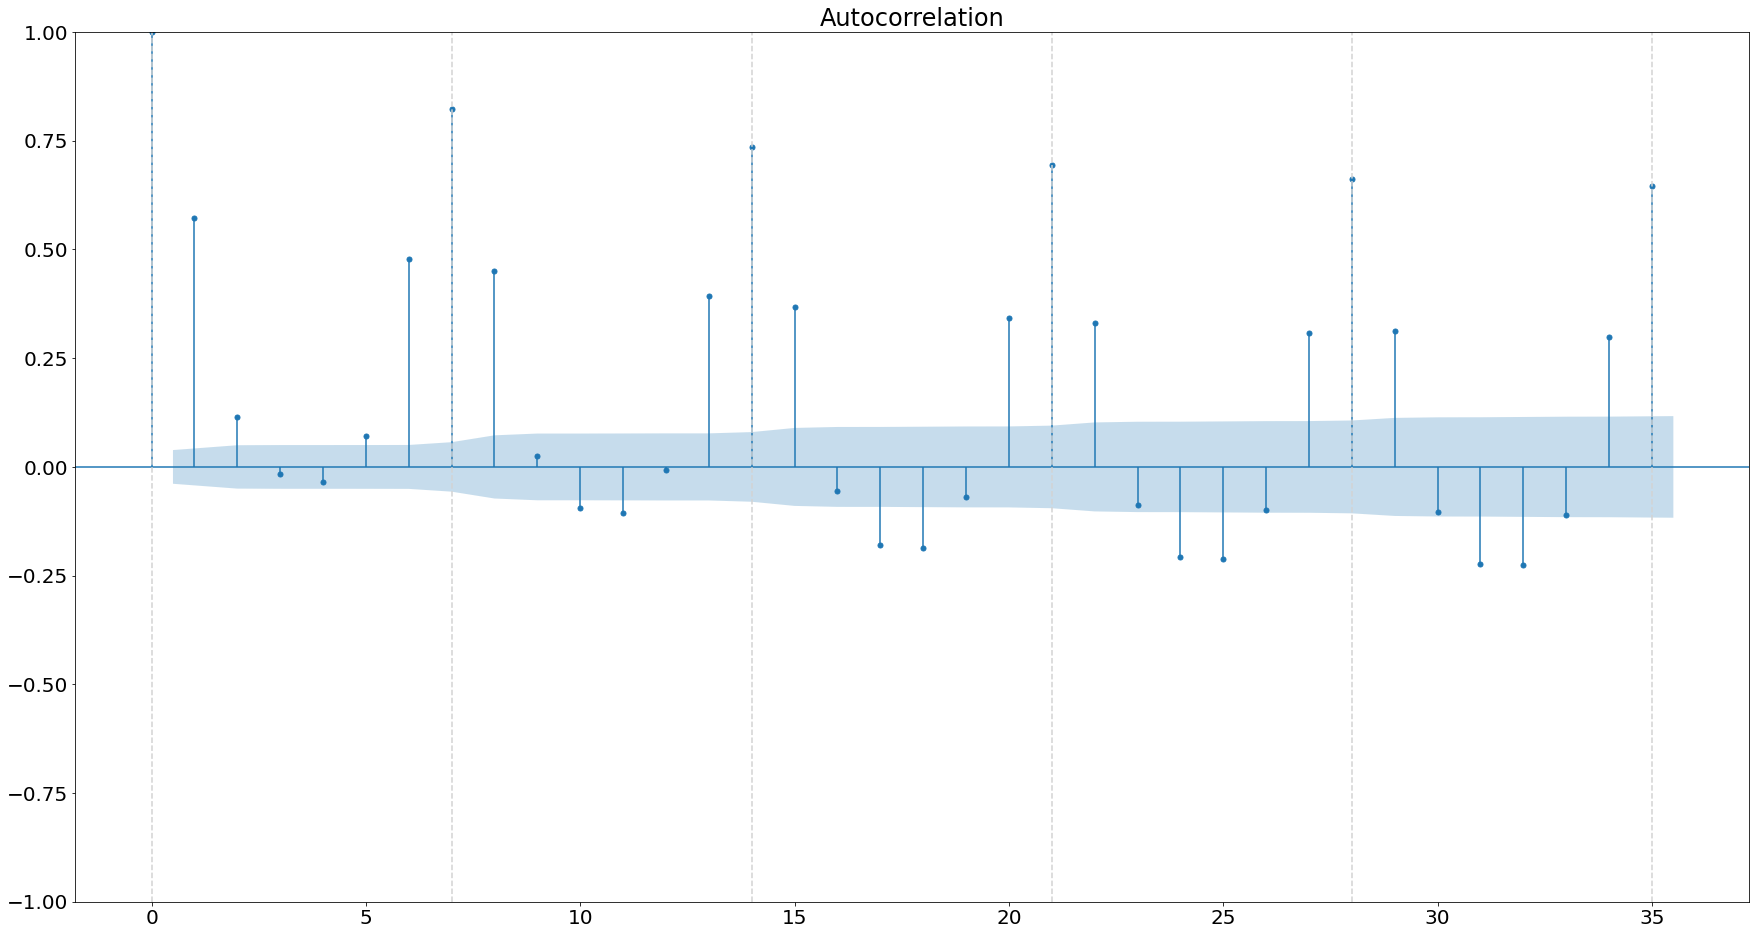

In [25]:
plot_acf(df["verbrauch"], lags=365);

for x in range(0, 366, 7):
    
    plt.axvline(x=x, linestyle="--", color="lightgrey")

plot_acf(df["verbrauch"], lags=35);

for x in range(0, 36, 7):
    
    plt.axvline(x=x, linestyle="--", color="lightgrey")

## <font size="6">Partielle Autokorrelation <a class="anchor" id="2-01-partielleautokorrelation"></a></font>

<font size="5">Anhand des partiellen Autokorrelationsdiagramms lässt sich erkennen, dass vor allem das erste, sechste, siebte und achte Lag signifikant korrelieren. Danach nehmen die Korrelationen beständig ab.</font>

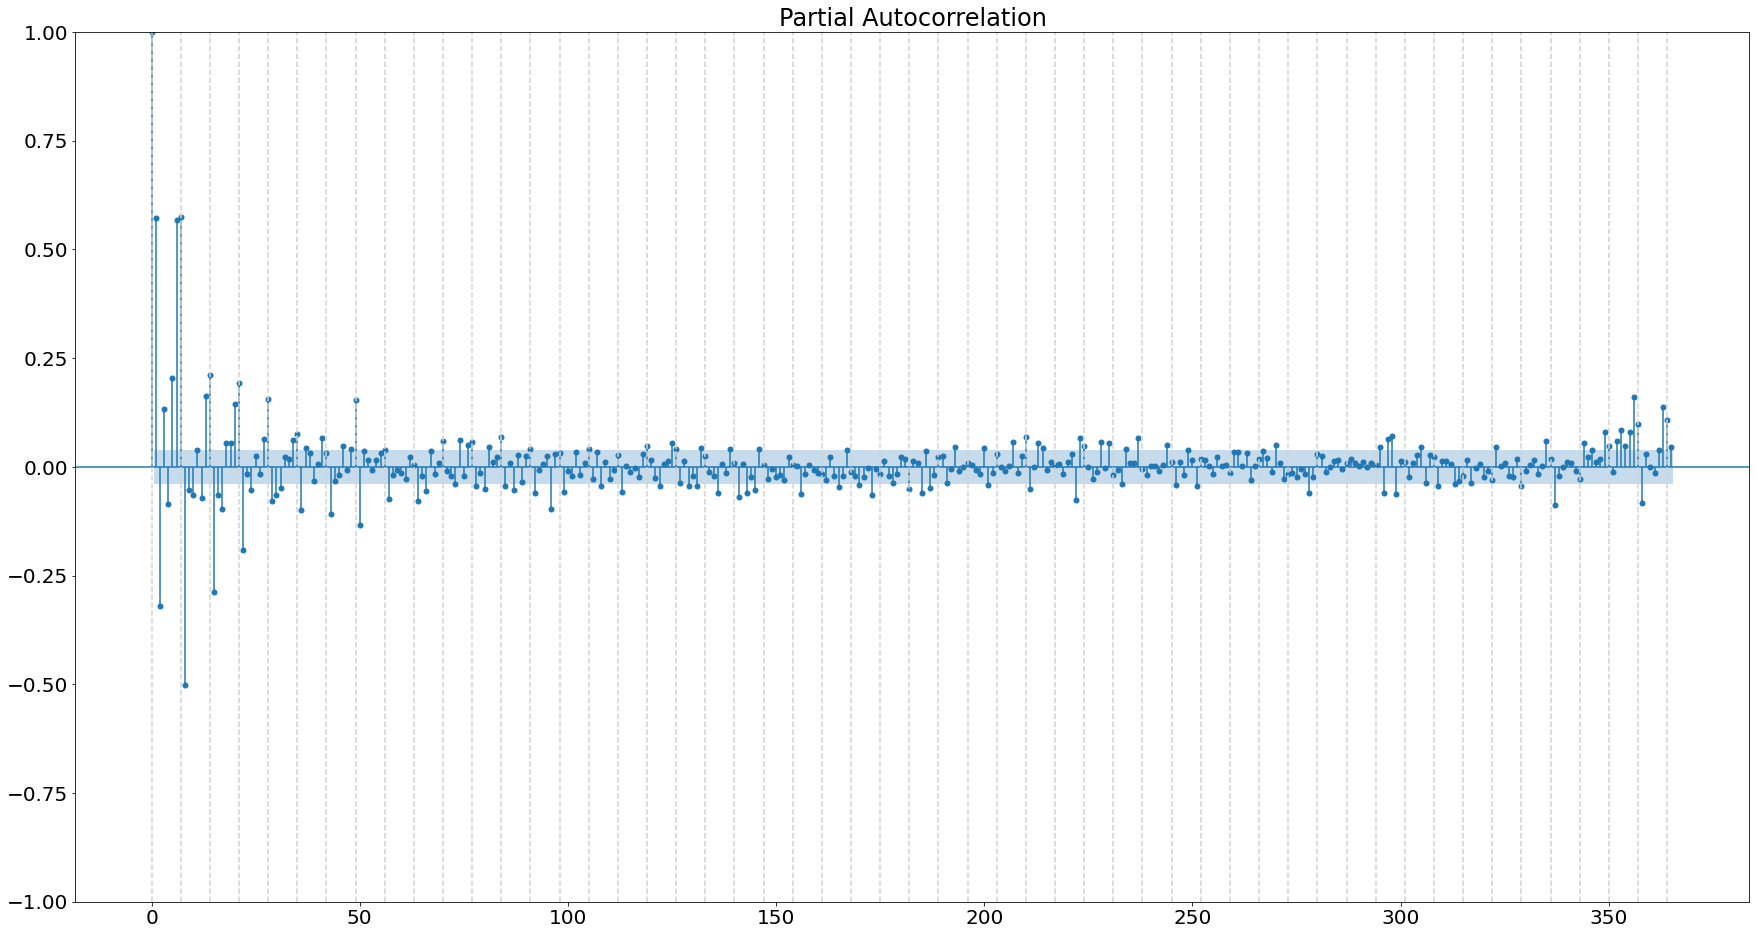

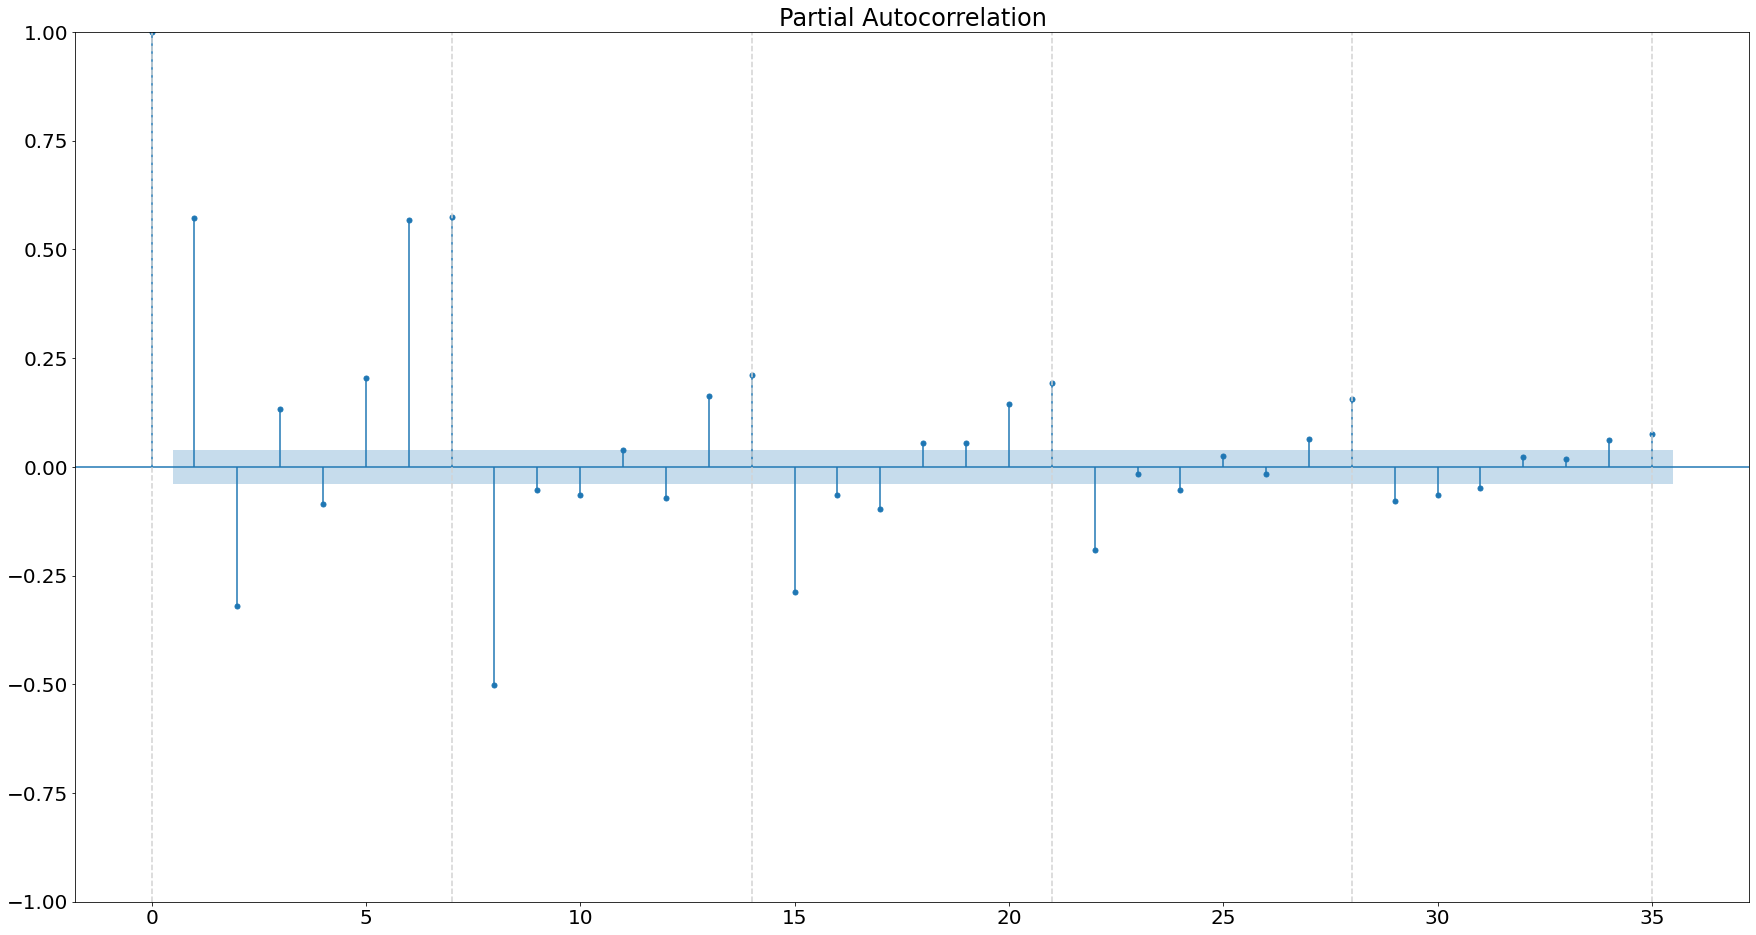

In [26]:
plot_pacf(df["verbrauch"], lags=365);

for x in range(0, 366, 7):
    
    plt.axvline(x=x, linestyle="--", color="lightgrey")

plot_pacf(df["verbrauch"], lags=35);

for x in range(0, 36, 7):
    
    plt.axvline(x=x, linestyle="--", color="lightgrey")

# <font size="7">Autoregressionsanalyse <a class="anchor" id="01-01-autoregressionsanalyse"></a></font>

<font size="5">Bei der Autoregressionsanalyse wird geprüft, in wie weit sich der Verlauf des Stromverbrauchs mittels der letzten Lags abbilden lässt. Anders als bei der Regressionsanalyse wird hierbei der Blick bereits auf die Fähigkeit zur Vorhersage gerichtet. Auch hier bietet sich eine Regression mittels einer Funktion sechsten Grades an, die mit den Daten von 2015 bis 2020 erstellt und mit den Daten für 2021 getestet wird.</font>

<font size="5">Bei der Autoregressionsanalyse mit den ersten sieben Lags zeigt sich, dass sich der Stromverbrauch mit 5 Lags besonders gut nachgebildet werden kann. Mit weniger Lags lässt sich der Verlauf schlechter abbilden, mit mehr Lags nimmt die Qualität besonders stark ab. Lediglich Feiertage und Ausreißer können sehr schlecht eingefangen werden.</font>

            verbrauch     lag 1     lag 2
datum                                    
2015-01-03   141426.0  147085.0  126197.0
2015-01-04   132446.0  141426.0  147085.0
2015-01-05   152611.0  132446.0  141426.0
2015-01-06   140474.0  152611.0  132446.0
2015-01-07   184936.0  140474.0  152611.0
...               ...       ...       ...
2021-12-27   153489.0  138335.0  137604.0
2021-12-28   155182.0  153489.0  138335.0
2021-12-29   153611.0  155182.0  153489.0
2021-12-30   148126.0  153611.0  155182.0
2021-12-31   137327.0  148126.0  153611.0

[2555 rows x 3 columns]
       Vorhersage
R2            0.5
MAE       13231.7
MSE   325366900.2
RMSE      18037.9
                 
MAPE        7.6 %


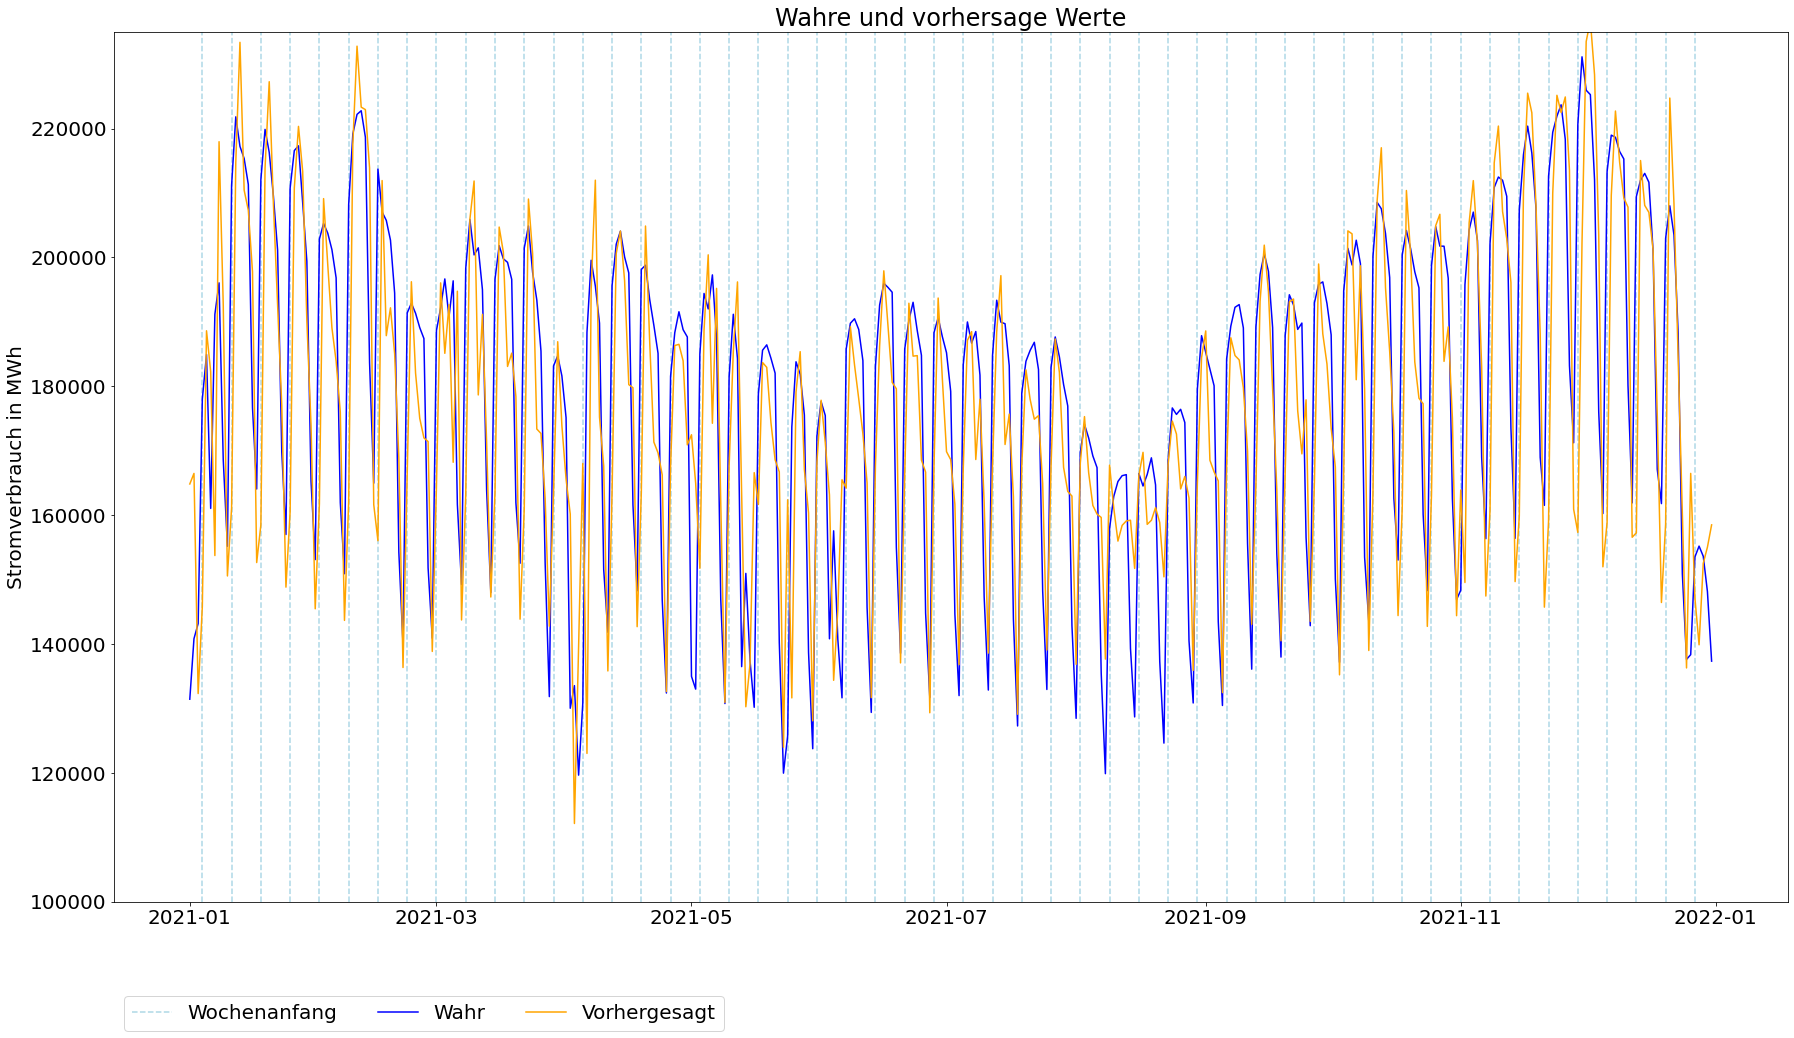

In [20]:
#Versetze Zeitreihen bzw. Lags als Feature erstellen
df_regression = pd.DataFrame(data=[df["verbrauch"], df["verbrauch"].shift(1), df["verbrauch"].shift(2)])
df_regression = df_regression.transpose()
df_regression = df_regression.dropna()
df_regression.columns = ["verbrauch", "lag 1", "lag 2"]

print(df_regression)

#Train-/Test-Split
train, test = functions.train_test_split(df_regression, 365)

#Polynomiale Regression sechsten Grades
pf = PolynomialFeatures(degree=6)
pf = pf.fit(df_regression.iloc[:,1:3].values)

y_train = train["verbrauch"]
y_test = test["verbrauch"]

X_train = pf.transform(train.iloc[:,1:3])
X_test = pf.transform(test.iloc[:,1:3])

#Regressionsmodel erstellen
model = LinearRegression().fit(X_train, y_train)

#Vorhersagen erstellen
preds = model.predict(X_test)
preds = pd.Series(data=preds, index=pd.date_range('01/01/2021', periods=365, freq='D')).rename("vorhergesagter verbrauch")

#Auswertung
functions.custom_metrics(y_test, preds)

            verbrauch     lag 1     lag 2     lag 6     lag 7
datum                                                        
2015-01-08   190395.0  184936.0  140474.0  147085.0  126197.0
2015-01-09   186902.0  190395.0  184936.0  141426.0  147085.0
2015-01-10   150311.0  186902.0  190395.0  132446.0  141426.0
2015-01-11   140494.0  150311.0  186902.0  152611.0  132446.0
2015-01-12   194573.0  140494.0  150311.0  140474.0  152611.0
...               ...       ...       ...       ...       ...
2021-12-27   153489.0  138335.0  137604.0  208005.0  202954.0
2021-12-28   155182.0  153489.0  138335.0  203472.0  208005.0
2021-12-29   153611.0  155182.0  153489.0  188233.0  203472.0
2021-12-30   148126.0  153611.0  155182.0  150890.0  188233.0
2021-12-31   137327.0  148126.0  153611.0  137604.0  150890.0

[2550 rows x 5 columns]
       Vorhersage
R2            0.8
MAE        7060.2
MSE   134381691.4
RMSE      11592.3
                 
MAPE        4.1 %


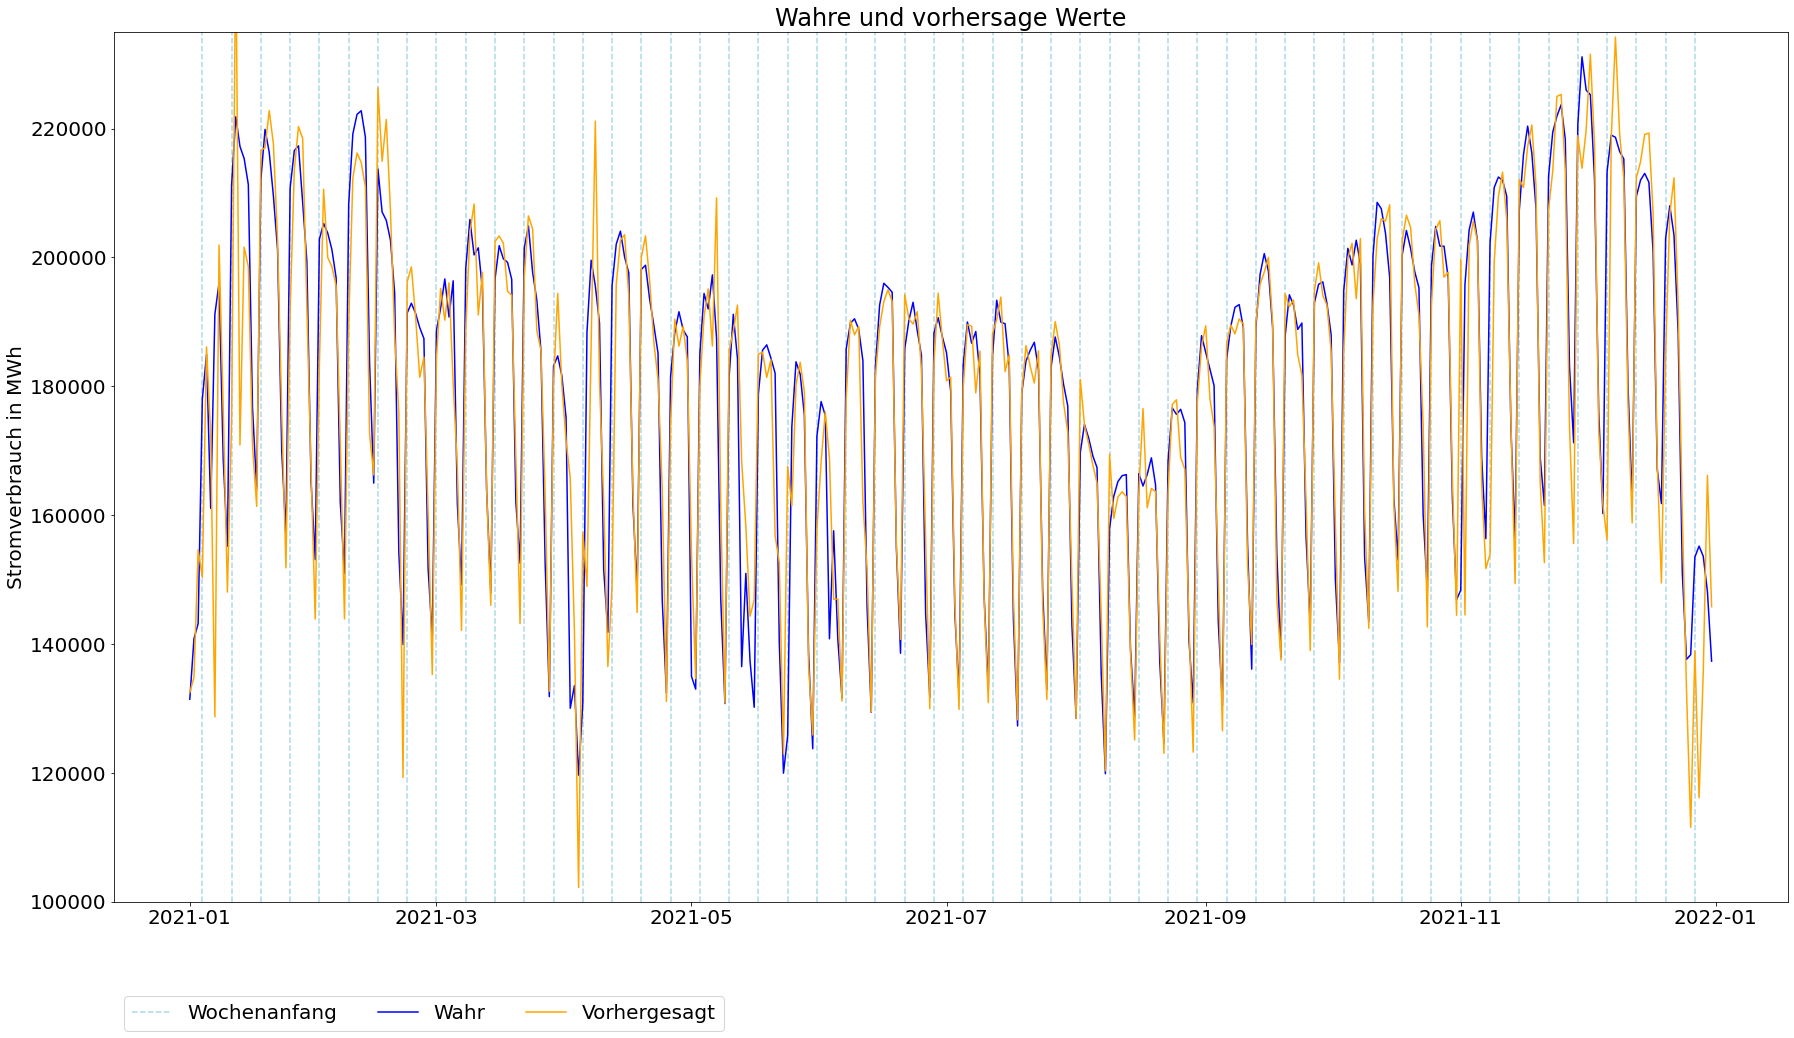

In [21]:
#Versetze Zeitreihen bzw. Lags als Feature erstellen
df_regression = pd.DataFrame(data=[df["verbrauch"], df["verbrauch"].shift(1), df["verbrauch"].shift(2), df["verbrauch"].shift(6), df["verbrauch"].shift(7)])
df_regression = df_regression.transpose()
df_regression = df_regression.dropna()
df_regression.columns = ["verbrauch", "lag 1", "lag 2", "lag 6", "lag 7"]

print(df_regression)

#Train-/Test-Split
train, test = functions.train_test_split(df_regression, 365)

#Polynomiale Regression sechsten Grades
pf = PolynomialFeatures(degree=6)
pf = pf.fit(df_regression.iloc[:,1:5].values)

y_train = train["verbrauch"]
y_test = test["verbrauch"]

X_train = pf.transform(train.iloc[:,1:5])
X_test = pf.transform(test.iloc[:,1:5])

#Regressionsmodel erstellen
model = LinearRegression().fit(X_train, y_train)

#Vorhersagen erstellen
preds = model.predict(X_test)
preds = pd.Series(data=preds, index=pd.date_range('01/01/2021', periods=365, freq='D')).rename("vorhergesagter verbrauch")

#Auswertung
functions.custom_metrics(y_test, preds)

# <font size="7">Fazit</font>
<font size="5">Der Stromverbrauch folgt einer jährlichen und einer wöchentlichen Saisonalität. Die wöchentliche Saisonalität ist vom Wochentag abhängig, montags bis freitags ist der Stromverbrauch sehr viel höher als samstags und sonntags. Feiertage bilden eine Ausnahme, sie sind auf dem gleichen Level wie Samstage oder Sonntage und werden daher den arbeitsfreien Tagen zugezählt. Es gibt signifikante Autokorrelationen und die Daten sind stationär.</font>

## <font size="6">Daten speichern</font>

<font size="5">Die als relevant und aussagekräftig ermittelten oder für Analysen relevanten Daten werden in der Datei „data.csv“ zwischengespeichert.</font>

In [22]:
df = df[["verbrauch", "monat", "wochentag", "arbeitstag"]]

print(df)

df.to_csv("data.csv")

            verbrauch     monat   wochentag  arbeitstag
datum                                                  
2015-01-01     126197    Januar  Donnerstag           0
2015-01-02     147085    Januar     Freitag           1
2015-01-03     141426    Januar     Samstag           0
2015-01-04     132446    Januar     Sonntag           0
2015-01-05     152611    Januar      Montag           1
...               ...       ...         ...         ...
2021-12-27     153489  Dezember      Montag           1
2021-12-28     155182  Dezember    Dienstag           1
2021-12-29     153611  Dezember    Mittwoch           1
2021-12-30     148126  Dezember  Donnerstag           1
2021-12-31     137327  Dezember     Freitag           1

[2557 rows x 4 columns]
